In [1]:

from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits, ascii
from astropy.coordinates import Angle, SkyCoord
from astropy.nddata import Cutout2D
from astropy.modeling import models, fitting
from astropy import time
import astropy.units as un
import numpy as np
import pandas as pd


from matplotlib.patches import Ellipse, Rectangle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.legend_handler import HandlerTuple


from scipy.optimize import curve_fit, minimize
import scipy.stats as stats
from scipy.special import gamma
import emcee
import corner



# import warnings
# warnings.filterwarnings("ignore");

#### Functions (Most Recent)

In [2]:
def beam(hdu):
    """input fits hdu"""
    beam_dict = {};
    beam_dict = {"b_major": hdu.header['BMAJ'], "b_minor": hdu.header['BMIN'], "b_pa": hdu.header['BPA']};
    #All units in degree
    
    return(beam_dict)


def info(hdu, in_center_dict=None):
    """inpt fits hdu"""
    if (str(hdu.__class__) == "<class 'astropy.io.fits.hdu.image.PrimaryHDU'>"):
        
        info_dict = {};
        info_dict = { "obs_code": hdu.header['OBSERVER'], "obs_date": hdu.header['DATE-OBS'],
                 "obsra": hdu.header['OBSRA'], "obsdec": hdu.header['OBSDEC'],
                 "rms": hdu.header['NOISE'], "min": hdu.header['DATAMIN'], "max": hdu.header['DATAMAX']};
        center_dict = {};
        center_dict = {"centpxl_ra": hdu.header['CRPIX1'], "centpxl_dec": hdu.header['CRPIX2'],
                "center_ra": hdu.header['CRVAL1'], "center_dec": hdu.header['CRVAL2'],
                "scale_ra": hdu.header['CDELT1'], "scale_dec": hdu.header['CDELT2'],
                "npxl_ra": hdu.header['NAXIS1'], "npxl_dec": hdu.header['NAXIS2']};
        return(info_dict, center_dict);
        
    elif (str(hdu.__class__) == "<class 'astropy.io.fits.header.Header'>"):
        
        info_dict = {};
        info_dict = { "obs_date": hdu['DATE-OBS']};
        center_dict = in_center_dict;
        center_dict |= {"centpxl_ra": hdu['CRPIX1'], "centpxl_dec": hdu['CRPIX2'],
                "center_ra": hdu['CRVAL1'], "center_dec": hdu['CRVAL2'],
                "scale_ra": hdu['CDELT1'], "scale_dec": hdu['CDELT2']};
        return(info_dict, center_dict);
    else:
        print("The input is not a hdu object, it's:",str(hdu.__class__));

def load(filename):
    """input filename/path, will output hdu data, wcs, and hdu."""
    hdu = fits.open(filename)[0];
    hdu_data = hdu.data[0][0];
    wcs_tmp = WCS(hdu.header);
    wcs_tmp1 = wcs_tmp.dropaxis(3);
    wcs = wcs_tmp1.dropaxis(2);
    
    return(hdu_data, wcs, hdu)

# def open(filename):
#     """Input filename/path, output is data"""
#     img_data, wcs, image_hdu = load(filename);
    
#     img_info, center_data = info(image);
#     beam_data = beam(image);
    
#     allinone = (img_info | beam_data | center_data);
#     return(img_data, wcs, image, allinone)

## Cutting function
def cut(data, in_wcs, center_dict, center_pos, box):
    """input data, wcs, center dictionary, center position and size of cutout."""
    size = un.Quantity(box, un.pix);
    
    cutout = Cutout2D(data, position=center_pos, size=size, wcs=in_wcs, copy=True);
    cutout_wcs = cutout.wcs.to_header();
    wcs_cut = WCS(cutout_wcs);
    cutout_data = cutout.data;
    
    center_tmp = cutout.center_cutout;
    # center_coord = wcs_cut.pixel_to_world(center_tmp[0],[1]);
    _ , new_center_dict = info(cutout_wcs, center_dict);
    # new_center_dict = {'centpxl_ra': center_coord.ra.degree, 'centpxl_dec':center_coord.dec.degree,
    #                   'center_ra': center_tmp[0], 'center_dec': center_tmp[1]};
    new_center_dict |= {'centpxl_ra': center_tmp[0], 'centpxl_dec':center_tmp[1],
                      'center_ra':center_pos.ra.degree, 'center_dec':center_pos.dec.degree,
                       'npxl_ra': size[0].value, 'npxl_dec':size[1].value};
    
    return(cutout_data, wcs_cut, new_center_dict);

##    # ploting functions
def scale(beam_dict, size):
    """input beam dictionary, and size of scale bar."""
    b_conv = (3600*1e3);
    beamsize = (beam_dict['b_major']*b_conv);
    sbar_scale = (size/beamsize);
    width = (beam_dict['b_major']*sbar_scale);

    return(width);

def beam_plotter(beam_dict, center_dict, ax_name):
    
    ra_offset = (center_dict['npxl_ra']/2 - 25)*center_dict['scale_ra'];
    dec_offset = (center_dict['npxl_dec']/2 )*center_dict['scale_dec'];
   
    beam_ra = (center_dict['center_ra'] - ra_offset + beam_dict['b_major']/2); 
    beam_dec = (center_dict['center_dec'] - dec_offset + beam_dict['b_major']);
    
    beam = Ellipse((beam_ra, beam_dec), height=beam_dict['b_major'], width = beam_dict['b_minor'], 
                   angle=beam_dict['b_pa'], transform=ax_name.get_transform('fk5'), edgecolor='w',
                   facecolor='w', alpha=0.7, lw=2);
    return(beam);

def sbar_plotter(center_dict, beam_dict, sbar_width_ang, ax_name, finetune_ra=0, finetune_dec=0):
    """"Input center dictionary, beam dictionary, size of scale bar in mas image axis name
    additionally, you can fine tune the placement with fintune_ra & finetune_dec"""
    b_conv = (3600*1e3);
    beamsize = (beam_dict['b_major']*b_conv);
    sbar_scale = (sbar_width_ang/beamsize);
    
    sbarwidth = (beam_dict['b_major']*sbar_scale);
    
    sbar_ra_offset = (center_dict['npxl_ra']/2 - 20);
    sbar_dec_offset = (center_dict['npxl_dec']/2 - 15);
    
    sbar_rad = (center_dict['center_ra'] + sbar_ra_offset*center_dict['scale_ra']);
    sbar_dec = (center_dict['center_dec'] - sbar_dec_offset*center_dict['scale_dec']);
    
    
    sbartxt = str(sbar_width_ang) + ' mas';
  
    sbar_ra_txt = (sbar_ra_offset - 5*sbar_width_ang+ finetune_ra);
    sbar_dec_txt = (sbar_dec_offset- 7 + finetune_dec);
    
    sbar_txt_rad = (center_dict['center_ra'] +
                    sbar_ra_txt*center_dict['scale_ra']);
    sbar_txt_dec = (center_dict['center_dec'] - sbar_dec_txt*center_dict['scale_dec']);

    sbar = Rectangle((sbar_rad, sbar_dec), width = sbarwidth, height = beam_dict['b_minor']/10,
                    transform=ax_name.get_transform('fk5'), color='w', facecolor='w', lw=2);
                     
    return(sbar, sbartxt, sbar_txt_rad, sbar_txt_dec);

def difmap_model_read(modelfit_file):
    """reads the output of difmap model files, path to file is needed."""
    header_names = ['Flux (Jy)', 'Flux (jy) Std', 'East (arcsec)', 'RA (arcsec) Std', 'North (arcsec)', 'Dec (arcsec) Std', 'Shape', 'R.A. (deg)', 'Dec (deg)',
        'Major FWHM (arcsec)', 'Major Std', 'Minor FWHM (arcsec)', 'Minor Std', 'Theta (deg)', 'Theta Std', 'Freq (Hz)', 'Spectral Index', 'Spec Indx Std' ];
    
    difmap_df = pd.read_csv(modelfit_file, header=None, sep=r'\s+', skiprows=[0,1,2], engine='python', names=header_names, skipinitialspace=True);
    # difmap_coords = 1;
    difmap_coords = SkyCoord(difmap_df.iloc[0,7], difmap_df.iloc[0,8], unit=(un.degree, un.degree),
                             obstime="J2000", frame='fk5');

    return(difmap_df, difmap_coords);

def angular_size(distance: int, angular_size):
    """distance needs to be in pc and angular size in arcsec"""
    dist = distance*un.pc;
    input = angular_size*un.arcsec;
    theta = input.to(un.rad);
    Diam = np.tan(theta)*dist;
    Diam_AU = Diam.to(un.AU);  
    print(f'{Diam:.3E}',f'{Diam_AU:.3E}');
    
    return  Diam, Diam_AU;
def angular_sizes(distance: int, angular_size, upper=0, lower=0):
    """distance needs to be in pc and angular size in arcsec"""
    if upper != 0:
        dist = distance*un.pc;
        dist_up = (distance+upper)*un.pc;
        dist_lo = (distance-lower)*un.pc;
        input = angular_size*un.arcsec;
        theta = input.to(un.rad);
        Diam_up = np.tan(theta)*dist_up;
        Diam_lo = np.tan(theta)*dist_lo;
        Diam = np.tan(theta)*dist;
        Diamlo_AU = Diam_lo.to(un.AU);  
        Diamup_AU = Diam_up.to(un.AU); 
        Diam_AU = Diam.to(un.AU); 
        print("Diameter (pc, AU):",f'{Diam:.3E}',f'{Diam_AU:.3E}',
              "Upper Diameter", f'{Diam_up:.3E}',f'{Diamup_AU:.3E}',
              "Lower Diameter", f'{Diam_lo:.3E}',f'{Diamlo_AU:.3E}' )
    elif upper ==0:    
        dist = distance*un.pc;
        input = angular_size*un.arcsec;
        theta = input.to(un.rad);
        Diam = np.tan(theta)*dist;
        Diam_AU = Diam.to(un.AU);  
        print(f'{Diam:.3E}',f'{Diam_AU:.3E}');
    
    return  Diam, Diam_AU;

def magnetic_field(pl, flux, Diameter, nu, K_o=40, f=1, i=0, si=-0.7):
    """path length (pl), flux, and Diameter must be an astropy unit object, can specify K_o, f, i, or alpha (spectral index (si))
        assumes 10% of radius as the emitting region"""
    l = (0.1*pl.to(un.cm)).value;
    a = -1*si;
    S_nu = ((flux*un.Jy).cgs).value;
    D = (Diameter*un.arcsec).to(un.rad).value;
    
    I_nu = S_nu/D**2;
    E_p = ((938.257 *un.MeV).cgs).value;
    freq = ((nu*un.Hz).cgs).value;


    #constants 
    C3 = (1.86558e-23);
    C1 =(6.62428e18);
    # C2 = 0.25*C3* (a+5/3)/(a+1) * gamma(1+3a)*gamma((3*a+5)/6);
    C2 = 0.25*C3* (a+5/3)/(a+1) * gamma(1+3*a)*gamma((2*a+3)/4);
    # C2 = C2.decompose();
    C4 = np.cos(i)**(a+1);

    # exp = 1/(a+3);
    one = (4*np.pi*(2*a+1)*(K_o+1)*I_nu*(E_p**(1-2*a)));
    two = ((freq/(2*C1))**a);
    three = ((2*a-1)*C2*l*C4*f);
    B_eq = ((one*two)/three)**(1/(a+3));
    B_min = B_eq * ((a+1)/2)**(1/(a+3));
    print(B_eq, "Gauss, K_0:", K_o, "path length (cm):", f'{l:.2E}');
    return B_eq, B_min

def brightness_temp(theta_maj, theta_min, flux, freq):
    """ returns brightness temperature, needs theta in arcsec, flux in Jy, and frew"""
    rad_conv = (3600)**(-1)*(np.pi/180); #arcsec to rad
    jy = 10e-26;
    theta1 = theta_maj*rad_conv;
    theta2 = theta_min*rad_conv;
    k = 1.38e-23;
    c = 2.99e8;


    Tb = (c/freq)**2 * (flux*jy) * (2*k)**(-1) * ((4*np.log10(2))/(np.pi*theta1*theta2));

    print(f'{Tb:.2E}');
    return Tb

### Gaia Stuff

In [3]:
t_0 = time.Time(2459377.6903, format="jd", scale="utc");
t_0.fits #to get in readable format
# type(t_0)

'2021-06-12T04:34:01.920'

In [4]:
gaia_df = pd.read_csv('./tables/V1674HER_gaia.csv', delimiter=',');
v1674her_df = gaia_df.iloc[3];
v1674her_gaia = v1674her_df.to_dict();
#ra_pm = un.Quantity(v1674her_gaia['pmra'], unit=(un.mas/un.year));

gaia = SkyCoord(v1674her_gaia['ra'], v1674her_gaia['dec'], unit=(un.degree, un.degree), 
                obstime="J2016", pm_ra_cosdec=(v1674her_gaia['pmra']*(un.mas/un.year)), 
                pm_dec=(v1674her_gaia['pmdec']*(un.mas/un.year)));

ra_err = (v1674her_df['dec_error']*un.mas).to(un.degree).value;
dec_err = (v1674her_df['ra_error']*un.mas).to(un.degree).value;
rapm_err = (v1674her_df['pmra_error']*un.mas).to(un.degree).value;
decpm_err = (v1674her_df['pmdec_error']*un.mas).to(un.degree).value;

# gaia_xerr = (ra_err**2+rapm_err**2)**(1/2);
# gaia_yerr = (dec_err**2+rapm_err**2)**(1/2);



gaia_simbad = SkyCoord('284.37907767182', '+16.8943096496', unit=(un.deg), obstime="J2016");
gaia_simbad_fk5 = SkyCoord('18 57 30.9832440660', '+16 53 39.589542422', unit=(un.hourangle, un.degree), frame='fk5');


### Difmap Model fit

In [5]:
modelfitb, modelfitb_coords = difmap_model_read('./imfit/modelfitB_1.txt');
modelfitd, modelfitd_coords = difmap_model_read('./imfit/modelfitd.txt');
modelfitf, modelfitf_coords = difmap_model_read('./imfit/modelfitF.txt');

## Distance & Angular Size

In [6]:
# dist = 6.3e3*un.pc;
# input = modelfitb.iloc[0,9]*un.arcsec;
# theta = input.to(un.rad);
# Diam = np.tan(theta)*dist;
# Diam_AU = Diam.to(un.AU);
# print(f'{Diam_AU:.3E}')

MajorD_b, MajorD_AU_b = angular_size(modelfitb.iloc[0,9], 6.3e3);
MajorD_d, MajorD_AU_d = angular_size(modelfitd.iloc[0,9], 6.3e3);
MajorD_f, MajorD_AU_f = angular_size(modelfitf.iloc[0,9], 6.3e3);
print(" ");

MinorD_b, MinorD_AU_b = angular_size(modelfitb.iloc[0,11], 6.3e3);
MinorD_d, MinorD_AU_d = angular_size(modelfitd.iloc[0,11], 6.3e3);
MinorD_f, MinorD_AU_f = angular_size(modelfitf.iloc[0,11], 6.3e3);

3.272E-04 pc 6.749E+01 AU
4.060E-04 pc 8.375E+01 AU
7.201E-04 pc 1.485E+02 AU
 
2.885E-04 pc 5.950E+01 AU
1.564E-04 pc 3.225E+01 AU
2.223E-04 pc 4.585E+01 AU


In [11]:
print(modelfitf.iloc[0,9]*1e3, modelfitf.iloc[0,11]*1e3)

23.57 7.275


In [39]:
modelfitb## Images
### V1674HERB

#### data insert
imgb_data, wcsb, imageb = load("./V1674HERIMG/0130/V1674HERB_CLN.fits");

imgb_info, imgb_cnt = info(imageb);

beamb = beam(imageb);

cutb_data, cut_wcsb, cutb_center = cut(imgb_data, wcsb, imgb_cnt, center_pos=modelfitb_coords, box=(350,350));
obstime_b = time.Time(imgb_info['obs_date'], scale='utc');
obstime_b.format = ('jd');
# obstime_b.scale = ('utc');

t_b = obstime_b - t_0;
# t_b = (imgb_info['obs_date']+str(t_b_delt.value))
# t_b = time.Time()))
print(t_b);
shifted_gaia = gaia.apply_space_motion(new_obstime=time.Time(imgb_info['obs_date']));
gaia_time = time.Time('2457389.0', format='jd');
# gaia_time.format = ('byear');


# time_diff.format('jd');
# shifted_gaia = shifted_gaia_tmp;
# # .transform_to('fk5');
# shifted_gaia = shifted_gaia_tmp.transform_to('fk5');

kirill_gaia = SkyCoord('18:57:30.977059', '+16:53:39.48903', unit=(un.hourangle, un.degree));
center = SkyCoord('18:57:30.9774409028 ', '16:53:39.4886141804 ', unit=(un.hourangle, un.degree));

# kirill_gaia = kirill_gaia_tmp.transform_to('fk5');

print(shifted_gaia.separation(kirill_gaia).to(un.mas));
# imgd_info['obs_date']


time_diff_b = (obstime_b - gaia_time);
time_diff_b = (time_diff_b.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_b)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_b*rapm_err)**2)**(1/2);

imgb_info
#### plots
plt.style.use('./presentation.mplstyle');
plt.rcParams.update({'font.weight': 'heavy'});
figb = plt.figure(figsize=(13,11));
axb = figb.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_b = axb.coords[0];
dec_b = axb.coords[1];


axb.set_title(f'V1674HER \n 21 Days After Eruption');

imgb = axb.imshow(cutb_data, cmap='inferno', vmin=imgb_info['min'], vmax=imgb_info['max'], 
                 transform=axb.get_transform(cut_wcsb), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutb_center, beamb, 10, axb, finetune_ra=-3); #finetune_ra=-7
beamb_patch = beam_plotter(beamb, cutb_center, axb);


cbar_b = figb.colorbar(imgb, format="%4.2e"); 
cbar_b.ax.set_ylabel('Jy/beam'); 

ra_b.set_axislabel('RA (J2000)');
dec_b.set_axislabel('DEC (J2000)');

ra_b.set_ticklabel('black'); #required
dec_b.set_ticklabel('black');

axb.add_patch(beamb_patch);
axb.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgb_info['rms']*contour_levels_array;
axb.contour(cutb_data, levels=contour_levels , colors='w', alpha=0.6);

axb.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axb.get_transform('fk5'), color='w');

axb.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axb.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');

x = [modelfitb_coords.ra.degree, modelfitd_coords.ra.degree, modelfitf_coords.ra.degree];
y = [modelfitb_coords.dec.degree, modelfitd_coords.dec.degree, modelfitf_coords.dec.degree];

axb.plot(x, y, transform=axb.get_transform('fk5'), linewidth=2, color='w', marker='.');

axb.plot(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axb.get_transform('fk5'), 
         marker='X', color='white', label='24 Days after Eruption',  markersize=15, markeredgewidth=1, markeredgecolor='black');

axb.plot(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axb.get_transform('fk5'), markersize=15, marker='P', label='36 Days after Eruption',
         color='white', markeredgewidth=1, markeredgecolor='black');

# axb.plot(kirill_gaia.ra.degree, kirill_gaia.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

# axb.plot(cent
# er.ra.degree, center.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

axb.plot(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree, transform=axb.get_transform('fk5'),
         markersize=15, color='purple', marker='*', label='Center of Image Fit');
axb.legend();
# print(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree);
### V1674HERD
imgd_data, wcsd, imaged = load('./V1674HERIMG/0130/V1674HERD_CLN.fits');

imgd_info, imgd_cnt = info(imaged);

beamd = beam(imaged);

cutd_data, cut_wcsd, cutd_center = cut(imgd_data, wcsd, imgd_cnt, center_pos=modelfitb_coords, box=(350,350));

obstime_d = time.Time(imgd_info['obs_date'], scale='utc');
obstime_d.format = ('jd');
# obstime_b.scale = ('utc');

t_d = obstime_d - t_0;



time_diff_d = (obstime_b - gaia_time);
time_diff_d = (time_diff_d.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_d)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_d*rapm_err)**2)**(1/2);
plt.style.use('./presentation.mplstyle');

figd = plt.figure(figsize=(13,11));
axd = figd.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_d = axd.coords[0];
dec_d = axd.coords[1];


axd.set_title(f'V1674HER \n 24 Days After Eruption');

imgb = axd.imshow(cutd_data, cmap='inferno', vmin=imgd_info['min'], vmax=imgd_info['max'], 
                 transform=axd.get_transform(cut_wcsd), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutd_center, beamd, 10, axd, finetune_ra=-3);
beamb_patch = beam_plotter(beamd, cutd_center, axd);


cbar_d = figd.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

ra_d.set_axislabel('RA (J2000)');
dec_d.set_axislabel('DEC (J2000)');

ra_d.set_ticklabel('black'); #required
dec_d.set_ticklabel('black');

axd.add_patch(beamb_patch);
axd.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgd_info['rms']*contour_levels_array;
axd.contour(cutd_data, levels=contour_levels ,transform=axd.get_transform(cut_wcsd), colors='w', alpha=0.6);

axd.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axd.get_transform('fk5'), color='w');

axd.errorbar(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axd.get_transform('fk5'),
           color='purple', marker='*', label='Center of Image Fit');

axd.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axd.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
axd.legend();
### V1674HERF
imgf_data, wcsf, imagef = load('./V1674HERIMG/0130/V1674HERF_CLN.fits');

imgf_info, imgf_cnt = info(imagef);

beamf = beam(imagef);

cutf_data, cut_wcsf, cutf_center = cut(imgf_data, wcsf, imgf_cnt, center_pos=modelfitb_coords, box=(350,350));

obstime_f = time.Time(imgf_info['obs_date'], scale='utc');
obstime_f.format = ('jd');
# obstime_b.scale = ('utc');

t_f = obstime_f - t_0;


time_diff_f = (obstime_f - gaia_time);
time_diff_f = (time_diff_f.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_f)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_f*rapm_err)**2)**(1/2);
plt.style.use('./presentation.mplstyle');

figf = plt.figure(figsize=(13,11));
axf = figf.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
rad_f = axf.coords[0];
dec_f = axf.coords[1];


axf.set_title(f'V1674HER \n 36 Days After Eruption');

imgb = axf.imshow(cutf_data, cmap='inferno', vmin=imgf_info['min'], vmax=imgf_info['max'], 
                 transform=axf.get_transform(cut_wcsf), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutf_center, beamf, 10, axf, finetune_ra=-7);
beamf_patch = beam_plotter(beamf, cutf_center, axf);


cbar_d = figf.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

rad_f.set_axislabel('RA (J2000)');
dec_f.set_axislabel('DEC (J2000)');

rad_f.set_ticklabel('black'); #required
dec_f.set_ticklabel('black');

axf.add_patch(beamf_patch);
axf.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgf_info['rms']*contour_levels_array;
axf.contour(cutf_data, levels=contour_levels ,transform=axf.get_transform(cut_wcsf), colors='w', alpha=0.6);

axf.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axf.get_transform('fk5'), color='w');
v1674herf_coords = SkyCoord('18:57:30.9747036153', '16:53:39.4639746068', unit=(un.hourangle, un.deg), frame='icrs').transform_to(frame='fk5');

axf.errorbar(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axf.get_transform('fk5'),
           color='purple', marker='*', label='Model Fit Center');

axf.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axf.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
axf.legend();## Images
### V1674HERB

#### data insert
imgb_data, wcsb, imageb = load("./V1674HERIMG/0130/V1674HERB_CLN.fits");

imgb_info, imgb_cnt = info(imageb);

beamb = beam(imageb);

cutb_data, cut_wcsb, cutb_center = cut(imgb_data, wcsb, imgb_cnt, center_pos=modelfitb_coords, box=(350,350));
obstime_b = time.Time(imgb_info['obs_date'], scale='utc');
obstime_b.format = ('jd');
# obstime_b.scale = ('utc');

t_b = obstime_b - t_0;
# t_b = (imgb_info['obs_date']+str(t_b_delt.value))
# t_b = time.Time()))
print(t_b);
shifted_gaia = gaia.apply_space_motion(new_obstime=time.Time(imgb_info['obs_date']));
gaia_time = time.Time('2457389.0', format='jd');
# gaia_time.format = ('byear');


# time_diff.format('jd');
# shifted_gaia = shifted_gaia_tmp;
# # .transform_to('fk5');
# shifted_gaia = shifted_gaia_tmp.transform_to('fk5');

kirill_gaia = SkyCoord('18:57:30.977059', '+16:53:39.48903', unit=(un.hourangle, un.degree));
center = SkyCoord('18:57:30.9774409028 ', '16:53:39.4886141804 ', unit=(un.hourangle, un.degree));

# kirill_gaia = kirill_gaia_tmp.transform_to('fk5');

print(shifted_gaia.separation(kirill_gaia).to(un.mas));
# imgd_info['obs_date']


time_diff_b = (obstime_b - gaia_time);
time_diff_b = (time_diff_b.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_b)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_b*rapm_err)**2)**(1/2);

imgb_info
#### plots
plt.style.use('./presentation.mplstyle');
plt.rcParams.update({'font.weight': 'heavy'});
figb = plt.figure(figsize=(13,11));
axb = figb.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_b = axb.coords[0];
dec_b = axb.coords[1];


axb.set_title(f'V1674HER \n 21 Days After Eruption');

imgb = axb.imshow(cutb_data, cmap='inferno', vmin=imgb_info['min'], vmax=imgb_info['max'], 
                 transform=axb.get_transform(cut_wcsb), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutb_center, beamb, 10, axb, finetune_ra=-3); #finetune_ra=-7
beamb_patch = beam_plotter(beamb, cutb_center, axb);


cbar_b = figb.colorbar(imgb, format="%4.2e"); 
cbar_b.ax.set_ylabel('Jy/beam'); 

ra_b.set_axislabel('RA (J2000)');
dec_b.set_axislabel('DEC (J2000)');

ra_b.set_ticklabel('black'); #required
dec_b.set_ticklabel('black');

axb.add_patch(beamb_patch);
axb.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgb_info['rms']*contour_levels_array;
axb.contour(cutb_data, levels=contour_levels , colors='w', alpha=0.6);

axb.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axb.get_transform('fk5'), color='w');

axb.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axb.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');

x = [modelfitb_coords.ra.degree, modelfitd_coords.ra.degree, modelfitf_coords.ra.degree];
y = [modelfitb_coords.dec.degree, modelfitd_coords.dec.degree, modelfitf_coords.dec.degree];

axb.plot(x, y, transform=axb.get_transform('fk5'), linewidth=2, color='w', marker='.');

axb.plot(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axb.get_transform('fk5'), 
         marker='X', color='white', label='24 Days after Eruption',  markersize=15, markeredgewidth=1, markeredgecolor='black');

axb.plot(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axb.get_transform('fk5'), markersize=15, marker='P', label='36 Days after Eruption',
         color='white', markeredgewidth=1, markeredgecolor='black');

# axb.plot(kirill_gaia.ra.degree, kirill_gaia.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

# axb.plot(cent
# er.ra.degree, center.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

axb.plot(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree, transform=axb.get_transform('fk5'),
         markersize=15, color='purple', marker='*', label='Center of Image Fit');
axb.legend();
# print(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree);
### V1674HERD
imgd_data, wcsd, imaged = load('./V1674HERIMG/0130/V1674HERD_CLN.fits');

imgd_info, imgd_cnt = info(imaged);

beamd = beam(imaged);

cutd_data, cut_wcsd, cutd_center = cut(imgd_data, wcsd, imgd_cnt, center_pos=modelfitb_coords, box=(350,350));

obstime_d = time.Time(imgd_info['obs_date'], scale='utc');
obstime_d.format = ('jd');
# obstime_b.scale = ('utc');

t_d = obstime_d - t_0;



time_diff_d = (obstime_b - gaia_time);
time_diff_d = (time_diff_d.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_d)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_d*rapm_err)**2)**(1/2);
plt.style.use('./presentation.mplstyle');

figd = plt.figure(figsize=(13,11));
axd = figd.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_d = axd.coords[0];
dec_d = axd.coords[1];


axd.set_title(f'V1674HER \n 24 Days After Eruption');

imgb = axd.imshow(cutd_data, cmap='inferno', vmin=imgd_info['min'], vmax=imgd_info['max'], 
                 transform=axd.get_transform(cut_wcsd), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutd_center, beamd, 10, axd, finetune_ra=-3);
beamb_patch = beam_plotter(beamd, cutd_center, axd);


cbar_d = figd.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

ra_d.set_axislabel('RA (J2000)');
dec_d.set_axislabel('DEC (J2000)');

ra_d.set_ticklabel('black'); #required
dec_d.set_ticklabel('black');

axd.add_patch(beamb_patch);
axd.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgd_info['rms']*contour_levels_array;
axd.contour(cutd_data, levels=contour_levels ,transform=axd.get_transform(cut_wcsd), colors='w', alpha=0.6);

axd.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axd.get_transform('fk5'), color='w');

axd.errorbar(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axd.get_transform('fk5'),
           color='purple', marker='*', label='Center of Image Fit');

axd.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axd.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
axd.legend();
### V1674HERF
imgf_data, wcsf, imagef = load('./V1674HERIMG/0130/V1674HERF_CLN.fits');

imgf_info, imgf_cnt = info(imagef);

beamf = beam(imagef);

cutf_data, cut_wcsf, cutf_center = cut(imgf_data, wcsf, imgf_cnt, center_pos=modelfitb_coords, box=(350,350));

obstime_f = time.Time(imgf_info['obs_date'], scale='utc');
obstime_f.format = ('jd');
# obstime_b.scale = ('utc');

t_f = obstime_f - t_0;


time_diff_f = (obstime_f - gaia_time);
time_diff_f = (time_diff_f.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_f)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_f*rapm_err)**2)**(1/2);
plt.style.use('./presentation.mplstyle');

figf = plt.figure(figsize=(13,11));
axf = figf.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
rad_f = axf.coords[0];
dec_f = axf.coords[1];


axf.set_title(f'V1674HER \n 36 Days After Eruption');

imgb = axf.imshow(cutf_data, cmap='inferno', vmin=imgf_info['min'], vmax=imgf_info['max'], 
                 transform=axf.get_transform(cut_wcsf), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutf_center, beamf, 10, axf, finetune_ra=-7);
beamf_patch = beam_plotter(beamf, cutf_center, axf);


cbar_d = figf.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

rad_f.set_axislabel('RA (J2000)');
dec_f.set_axislabel('DEC (J2000)');

rad_f.set_ticklabel('black'); #required
dec_f.set_ticklabel('black');

axf.add_patch(beamf_patch);
axf.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgf_info['rms']*contour_levels_array;
axf.contour(cutf_data, levels=contour_levels ,transform=axf.get_transform(cut_wcsf), colors='w', alpha=0.6);

axf.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axf.get_transform('fk5'), color='w');
v1674herf_coords = SkyCoord('18:57:30.9747036153', '16:53:39.4639746068', unit=(un.hourangle, un.deg), frame='icrs').transform_to(frame='fk5');

axf.errorbar(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axf.get_transform('fk5'),
           color='purple', marker='*', label='Model Fit Center');

axf.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axf.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
axf.legend();## Images
### V1674HERB

#### data insert
imgb_data, wcsb, imageb = load("./V1674HERIMG/0130/V1674HERB_CLN.fits");

imgb_info, imgb_cnt = info(imageb);

beamb = beam(imageb);

cutb_data, cut_wcsb, cutb_center = cut(imgb_data, wcsb, imgb_cnt, center_pos=modelfitb_coords, box=(350,350));
obstime_b = time.Time(imgb_info['obs_date'], scale='utc');
obstime_b.format = ('jd');
# obstime_b.scale = ('utc');

t_b = obstime_b - t_0;
# t_b = (imgb_info['obs_date']+str(t_b_delt.value))
# t_b = time.Time()))
print(t_b);
shifted_gaia = gaia.apply_space_motion(new_obstime=time.Time(imgb_info['obs_date']));
gaia_time = time.Time('2457389.0', format='jd');
# gaia_time.format = ('byear');


# time_diff.format('jd');
# shifted_gaia = shifted_gaia_tmp;
# # .transform_to('fk5');
# shifted_gaia = shifted_gaia_tmp.transform_to('fk5');

kirill_gaia = SkyCoord('18:57:30.977059', '+16:53:39.48903', unit=(un.hourangle, un.degree));
center = SkyCoord('18:57:30.9774409028 ', '16:53:39.4886141804 ', unit=(un.hourangle, un.degree));

# kirill_gaia = kirill_gaia_tmp.transform_to('fk5');

print(shifted_gaia.separation(kirill_gaia).to(un.mas));
# imgd_info['obs_date']


time_diff_b = (obstime_b - gaia_time);
time_diff_b = (time_diff_b.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_b)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_b*rapm_err)**2)**(1/2);

imgb_info
#### plots
plt.style.use('./presentation.mplstyle');
plt.rcParams.update({'font.weight': 'heavy'});
figb = plt.figure(figsize=(13,11));
axb = figb.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_b = axb.coords[0];
dec_b = axb.coords[1];


axb.set_title(f'V1674HER \n 21 Days After Eruption');

imgb = axb.imshow(cutb_data, cmap='inferno', vmin=imgb_info['min'], vmax=imgb_info['max'], 
                 transform=axb.get_transform(cut_wcsb), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutb_center, beamb, 10, axb, finetune_ra=-3); #finetune_ra=-7
beamb_patch = beam_plotter(beamb, cutb_center, axb);


cbar_b = figb.colorbar(imgb, format="%4.2e"); 
cbar_b.ax.set_ylabel('Jy/beam'); 

ra_b.set_axislabel('RA (J2000)');
dec_b.set_axislabel('DEC (J2000)');

ra_b.set_ticklabel('black'); #required
dec_b.set_ticklabel('black');

axb.add_patch(beamb_patch);
axb.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgb_info['rms']*contour_levels_array;
axb.contour(cutb_data, levels=contour_levels , colors='w', alpha=0.6);

axb.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axb.get_transform('fk5'), color='w');

axb.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axb.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');

x = [modelfitb_coords.ra.degree, modelfitd_coords.ra.degree, modelfitf_coords.ra.degree];
y = [modelfitb_coords.dec.degree, modelfitd_coords.dec.degree, modelfitf_coords.dec.degree];

axb.plot(x, y, transform=axb.get_transform('fk5'), linewidth=2, color='w', marker='.');

axb.plot(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axb.get_transform('fk5'), 
         marker='X', color='white', label='24 Days after Eruption',  markersize=15, markeredgewidth=1, markeredgecolor='black');

axb.plot(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axb.get_transform('fk5'), markersize=15, marker='P', label='36 Days after Eruption',
         color='white', markeredgewidth=1, markeredgecolor='black');

# axb.plot(kirill_gaia.ra.degree, kirill_gaia.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

# axb.plot(cent
# er.ra.degree, center.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

axb.plot(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree, transform=axb.get_transform('fk5'),
         markersize=15, color='purple', marker='*', label='Center of Image Fit');
axb.legend();
# print(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree);
### V1674HERD
imgd_data, wcsd, imaged = load('./V1674HERIMG/0130/V1674HERD_CLN.fits');

imgd_info, imgd_cnt = info(imaged);

beamd = beam(imaged);

cutd_data, cut_wcsd, cutd_center = cut(imgd_data, wcsd, imgd_cnt, center_pos=modelfitb_coords, box=(350,350));

obstime_d = time.Time(imgd_info['obs_date'], scale='utc');
obstime_d.format = ('jd');
# obstime_b.scale = ('utc');

t_d = obstime_d - t_0;



time_diff_d = (obstime_b - gaia_time);
time_diff_d = (time_diff_d.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_d)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_d*rapm_err)**2)**(1/2);
plt.style.use('./presentation.mplstyle');

figd = plt.figure(figsize=(13,11));
axd = figd.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_d = axd.coords[0];
dec_d = axd.coords[1];


axd.set_title(f'V1674HER \n 24 Days After Eruption');

imgb = axd.imshow(cutd_data, cmap='inferno', vmin=imgd_info['min'], vmax=imgd_info['max'], 
                 transform=axd.get_transform(cut_wcsd), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutd_center, beamd, 10, axd, finetune_ra=-3);
beamb_patch = beam_plotter(beamd, cutd_center, axd);


cbar_d = figd.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

ra_d.set_axislabel('RA (J2000)');
dec_d.set_axislabel('DEC (J2000)');

ra_d.set_ticklabel('black'); #required
dec_d.set_ticklabel('black');

axd.add_patch(beamb_patch);
axd.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgd_info['rms']*contour_levels_array;
axd.contour(cutd_data, levels=contour_levels ,transform=axd.get_transform(cut_wcsd), colors='w', alpha=0.6);

axd.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axd.get_transform('fk5'), color='w');

axd.errorbar(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axd.get_transform('fk5'),
           color='purple', marker='*', label='Center of Image Fit');

axd.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axd.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
axd.legend();
### V1674HERF
imgf_data, wcsf, imagef = load('./V1674HERIMG/0130/V1674HERF_CLN.fits');

imgf_info, imgf_cnt = info(imagef);

beamf = beam(imagef);

cutf_data, cut_wcsf, cutf_center = cut(imgf_data, wcsf, imgf_cnt, center_pos=modelfitb_coords, box=(350,350));

obstime_f = time.Time(imgf_info['obs_date'], scale='utc');
obstime_f.format = ('jd');
# obstime_b.scale = ('utc');

t_f = obstime_f - t_0;


time_diff_f = (obstime_f - gaia_time);
time_diff_f = (time_diff_f.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_f)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_f*rapm_err)**2)**(1/2);
plt.style.use('./presentation.mplstyle');

figf = plt.figure(figsize=(13,11));
axf = figf.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
rad_f = axf.coords[0];
dec_f = axf.coords[1];


axf.set_title(f'V1674HER \n 36 Days After Eruption');

imgb = axf.imshow(cutf_data, cmap='inferno', vmin=imgf_info['min'], vmax=imgf_info['max'], 
                 transform=axf.get_transform(cut_wcsf), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutf_center, beamf, 10, axf, finetune_ra=-7);
beamf_patch = beam_plotter(beamf, cutf_center, axf);


cbar_d = figf.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

rad_f.set_axislabel('RA (J2000)');
dec_f.set_axislabel('DEC (J2000)');

rad_f.set_ticklabel('black'); #required
dec_f.set_ticklabel('black');

axf.add_patch(beamf_patch);
axf.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgf_info['rms']*contour_levels_array;
axf.contour(cutf_data, levels=contour_levels ,transform=axf.get_transform(cut_wcsf), colors='w', alpha=0.6);

axf.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axf.get_transform('fk5'), color='w');
v1674herf_coords = SkyCoord('18:57:30.9747036153', '16:53:39.4639746068', unit=(un.hourangle, un.deg), frame='icrs').transform_to(frame='fk5');

axf.errorbar(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axf.get_transform('fk5'),
           color='purple', marker='*', label='Model Fit Center');

axf.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axf.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
axf.legend();## Images
### V1674HERB

#### data insert
imgb_data, wcsb, imageb = load("./V1674HERIMG/0130/V1674HERB_CLN.fits");

imgb_info, imgb_cnt = info(imageb);

beamb = beam(imageb);

cutb_data, cut_wcsb, cutb_center = cut(imgb_data, wcsb, imgb_cnt, center_pos=modelfitb_coords, box=(350,350));
obstime_b = time.Time(imgb_info['obs_date'], scale='utc');
obstime_b.format = ('jd');
# obstime_b.scale = ('utc');

t_b = obstime_b - t_0;
# t_b = (imgb_info['obs_date']+str(t_b_delt.value))
# t_b = time.Time()))
print(t_b);
shifted_gaia = gaia.apply_space_motion(new_obstime=time.Time(imgb_info['obs_date']));
gaia_time = time.Time('2457389.0', format='jd');
# gaia_time.format = ('byear');


# time_diff.format('jd');
# shifted_gaia = shifted_gaia_tmp;
# # .transform_to('fk5');
# shifted_gaia = shifted_gaia_tmp.transform_to('fk5');

kirill_gaia = SkyCoord('18:57:30.977059', '+16:53:39.48903', unit=(un.hourangle, un.degree));
center = SkyCoord('18:57:30.9774409028 ', '16:53:39.4886141804 ', unit=(un.hourangle, un.degree));

# kirill_gaia = kirill_gaia_tmp.transform_to('fk5');

print(shifted_gaia.separation(kirill_gaia).to(un.mas));
# imgd_info['obs_date']


time_diff_b = (obstime_b - gaia_time);
time_diff_b = (time_diff_b.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_b)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_b*rapm_err)**2)**(1/2);

imgb_info
#### plots
plt.style.use('./presentation.mplstyle');
plt.rcParams.update({'font.weight': 'heavy'});
figb = plt.figure(figsize=(13,11));
axb = figb.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_b = axb.coords[0];
dec_b = axb.coords[1];


axb.set_title(f'V1674HER \n 21 Days After Eruption');

imgb = axb.imshow(cutb_data, cmap='inferno', vmin=imgb_info['min'], vmax=imgb_info['max'], 
                 transform=axb.get_transform(cut_wcsb), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutb_center, beamb, 10, axb, finetune_ra=-3); #finetune_ra=-7
beamb_patch = beam_plotter(beamb, cutb_center, axb);


cbar_b = figb.colorbar(imgb, format="%4.2e"); 
cbar_b.ax.set_ylabel('Jy/beam'); 

ra_b.set_axislabel('RA (J2000)');
dec_b.set_axislabel('DEC (J2000)');

ra_b.set_ticklabel('black'); #required
dec_b.set_ticklabel('black');

axb.add_patch(beamb_patch);
axb.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgb_info['rms']*contour_levels_array;
axb.contour(cutb_data, levels=contour_levels , colors='w', alpha=0.6);

axb.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axb.get_transform('fk5'), color='w');

axb.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axb.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');

x = [modelfitb_coords.ra.degree, modelfitd_coords.ra.degree, modelfitf_coords.ra.degree];
y = [modelfitb_coords.dec.degree, modelfitd_coords.dec.degree, modelfitf_coords.dec.degree];

axb.plot(x, y, transform=axb.get_transform('fk5'), linewidth=2, color='w', marker='.');

axb.plot(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axb.get_transform('fk5'), 
         marker='X', color='white', label='24 Days after Eruption',  markersize=15, markeredgewidth=1, markeredgecolor='black');

axb.plot(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axb.get_transform('fk5'), markersize=15, marker='P', label='36 Days after Eruption',
         color='white', markeredgewidth=1, markeredgecolor='black');

# axb.plot(kirill_gaia.ra.degree, kirill_gaia.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

# axb.plot(cent
# er.ra.degree, center.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

axb.plot(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree, transform=axb.get_transform('fk5'),
         markersize=15, color='purple', marker='*', label='Center of Image Fit');
axb.legend();
# print(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree);
### V1674HERD
imgd_data, wcsd, imaged = load('./V1674HERIMG/0130/V1674HERD_CLN.fits');

imgd_info, imgd_cnt = info(imaged);

beamd = beam(imaged);

cutd_data, cut_wcsd, cutd_center = cut(imgd_data, wcsd, imgd_cnt, center_pos=modelfitb_coords, box=(350,350));

obstime_d = time.Time(imgd_info['obs_date'], scale='utc');
obstime_d.format = ('jd');
# obstime_b.scale = ('utc');

t_d = obstime_d - t_0;



time_diff_d = (obstime_b - gaia_time);
time_diff_d = (time_diff_d.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_d)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_d*rapm_err)**2)**(1/2);
plt.style.use('./presentation.mplstyle');

figd = plt.figure(figsize=(13,11));
axd = figd.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_d = axd.coords[0];
dec_d = axd.coords[1];


axd.set_title(f'V1674HER \n 24 Days After Eruption');

imgb = axd.imshow(cutd_data, cmap='inferno', vmin=imgd_info['min'], vmax=imgd_info['max'], 
                 transform=axd.get_transform(cut_wcsd), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutd_center, beamd, 10, axd, finetune_ra=-3);
beamb_patch = beam_plotter(beamd, cutd_center, axd);


cbar_d = figd.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

ra_d.set_axislabel('RA (J2000)');
dec_d.set_axislabel('DEC (J2000)');

ra_d.set_ticklabel('black'); #required
dec_d.set_ticklabel('black');

axd.add_patch(beamb_patch);
axd.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgd_info['rms']*contour_levels_array;
axd.contour(cutd_data, levels=contour_levels ,transform=axd.get_transform(cut_wcsd), colors='w', alpha=0.6);

axd.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axd.get_transform('fk5'), color='w');

axd.errorbar(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axd.get_transform('fk5'),
           color='purple', marker='*', label='Center of Image Fit');

axd.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axd.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
axd.legend();
### V1674HERF
imgf_data, wcsf, imagef = load('./V1674HERIMG/0130/V1674HERF_CLN.fits');

imgf_info, imgf_cnt = info(imagef);

beamf = beam(imagef);

cutf_data, cut_wcsf, cutf_center = cut(imgf_data, wcsf, imgf_cnt, center_pos=modelfitb_coords, box=(350,350));

obstime_f = time.Time(imgf_info['obs_date'], scale='utc');
obstime_f.format = ('jd');
# obstime_b.scale = ('utc');

t_f = obstime_f - t_0;


time_diff_f = (obstime_f - gaia_time);
time_diff_f = (time_diff_f.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_f)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_f*rapm_err)**2)**(1/2);
plt.style.use('./presentation.mplstyle');

figf = plt.figure(figsize=(13,11));
axf = figf.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
rad_f = axf.coords[0];
dec_f = axf.coords[1];


axf.set_title(f'V1674HER \n 36 Days After Eruption');

imgb = axf.imshow(cutf_data, cmap='inferno', vmin=imgf_info['min'], vmax=imgf_info['max'], 
                 transform=axf.get_transform(cut_wcsf), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutf_center, beamf, 10, axf, finetune_ra=-7);
beamf_patch = beam_plotter(beamf, cutf_center, axf);


cbar_d = figf.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

rad_f.set_axislabel('RA (J2000)');
dec_f.set_axislabel('DEC (J2000)');

rad_f.set_ticklabel('black'); #required
dec_f.set_ticklabel('black');

axf.add_patch(beamf_patch);
axf.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgf_info['rms']*contour_levels_array;
axf.contour(cutf_data, levels=contour_levels ,transform=axf.get_transform(cut_wcsf), colors='w', alpha=0.6);

axf.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axf.get_transform('fk5'), color='w');
v1674herf_coords = SkyCoord('18:57:30.9747036153', '16:53:39.4639746068', unit=(un.hourangle, un.deg), frame='icrs').transform_to(frame='fk5');

axf.errorbar(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axf.get_transform('fk5'),
           color='purple', marker='*', label='Model Fit Center');

axf.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axf.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
axf.legend();

,Flux (Jy),Flux (jy) Std,East (arcsec),RA (arcsec) Std,North (arcsec),Dec (arcsec) Std,Shape,R.A. (deg),Dec (deg),Major FWHM (arcsec),Major Std,Minor FWHM (arcsec),Minor Std,Theta (deg),Theta Std,Freq (Hz),Spectral Index,Spec Indx Std
0,0.001688,0.000062,-0.007585,0.00022,-0.001783,0.00018,gauss,284.379073,16.894302,0.01071,0.00066,0.009442,0.00094,-68.47,21.0,4.867750e+09,0.0,0.0


## Images

### V1674HERB


#### data insert

In [7]:
imgb_data, wcsb, imageb = load("./V1674HERIMG/0130/V1674HERB_CLN.fits");

imgb_info, imgb_cnt = info(imageb);

beamb = beam(imageb);

cutb_data, cut_wcsb, cutb_center = cut(imgb_data, wcsb, imgb_cnt, center_pos=modelfitb_coords, box=(350,350));
obstime_b = time.Time(imgb_info['obs_date'], scale='utc');
obstime_b.format = ('jd');
# obstime_b.scale = ('utc');

t_b = obstime_b - t_0;
# t_b = (imgb_info['obs_date']+str(t_b_delt.value))
# t_b = time.Time()))
print(t_b);
shifted_gaia = gaia.apply_space_motion(new_obstime=time.Time(imgb_info['obs_date']));
gaia_time = time.Time('2457389.0', format='jd');
# gaia_time.format = ('byear');


# time_diff.format('jd');
# shifted_gaia = shifted_gaia_tmp;
# # .transform_to('fk5');
# shifted_gaia = shifted_gaia_tmp.transform_to('fk5');

kirill_gaia = SkyCoord('18:57:30.977059', '+16:53:39.48903', unit=(un.hourangle, un.degree));
center = SkyCoord('18:57:30.9774409028 ', '16:53:39.4886141804 ', unit=(un.hourangle, un.degree));

# kirill_gaia = kirill_gaia_tmp.transform_to('fk5');

print(shifted_gaia.separation(kirill_gaia).to(un.mas));
# imgd_info['obs_date']


time_diff_b = (obstime_b - gaia_time);
time_diff_b = (time_diff_b.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_b)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_b*rapm_err)**2)**(1/2);


19.809700000099838
0.00444309 mas


/Users/mwilliam/astro/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


In [8]:
imgb_info

{'obs_code': 'BA142B',
 'obs_date': '2021-07-02',
 'obsra': 284.379079167,
 'obsdec': 16.8943166667,
 'rms': 1.165874346043e-05,
 'min': -7.0540867454838e-05,
 'max': 0.00014892035687808}

#### plots

/var/folders/k8/d570h55x0jddd1svnvdqq5m40000gn/T/ipykernel_56481/973989705.py:126: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  sbar = Rectangle((sbar_rad, sbar_dec), width = sbarwidth, height = beam_dict['b_minor']/10,


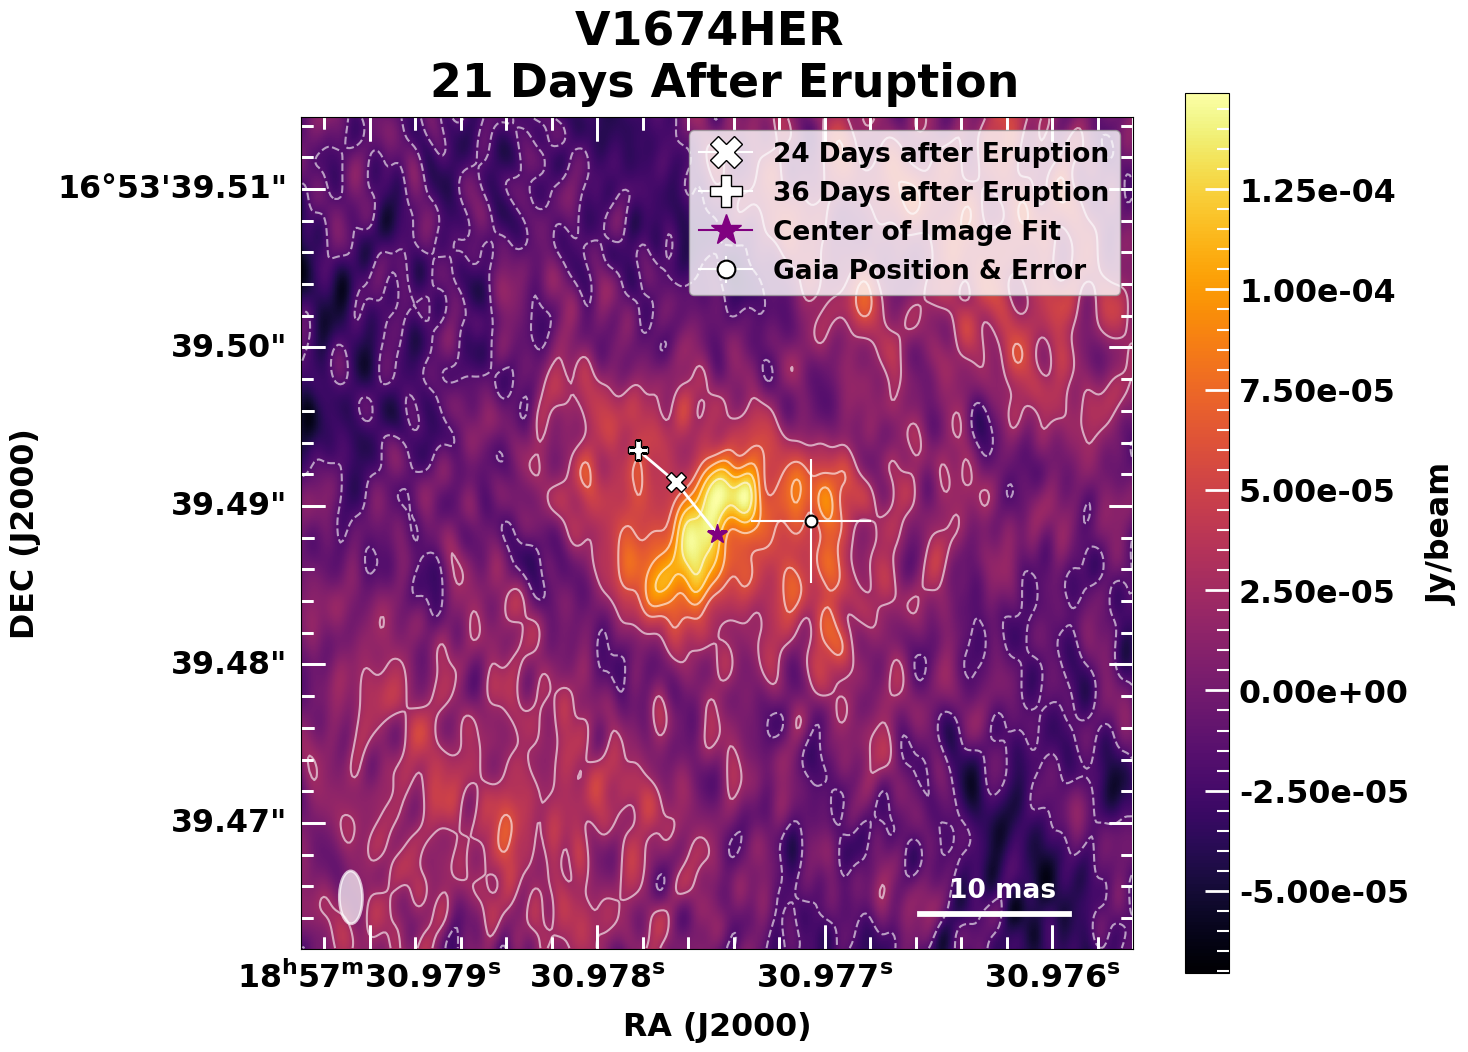

In [9]:
plt.style.use('./presentation.mplstyle');
plt.rcParams.update({'font.weight': 'heavy'});
figb = plt.figure(figsize=(13,11));
axb = figb.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_b = axb.coords[0];
dec_b = axb.coords[1];


axb.set_title(f'V1674HER \n 21 Days After Eruption');

imgb = axb.imshow(cutb_data, cmap='inferno', vmin=imgb_info['min'], vmax=imgb_info['max'], 
                 transform=axb.get_transform(cut_wcsb), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutb_center, beamb, 10, axb, finetune_ra=-3); #finetune_ra=-7
beamb_patch = beam_plotter(beamb, cutb_center, axb);


cbar_b = figb.colorbar(imgb, format="%4.2e"); 
cbar_b.ax.set_ylabel('Jy/beam'); 

ra_b.set_axislabel('RA (J2000)');
dec_b.set_axislabel('DEC (J2000)');

ra_b.set_ticklabel('black'); #required
dec_b.set_ticklabel('black');

axb.add_patch(beamb_patch);
axb.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgb_info['rms']*contour_levels_array;
axb.contour(cutb_data, levels=contour_levels , colors='w', alpha=0.6);

axb.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axb.get_transform('fk5'), color='w');

axb.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axb.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');

x = [modelfitb_coords.ra.degree, modelfitd_coords.ra.degree, modelfitf_coords.ra.degree];
y = [modelfitb_coords.dec.degree, modelfitd_coords.dec.degree, modelfitf_coords.dec.degree];

axb.plot(x, y, transform=axb.get_transform('fk5'), linewidth=2, color='w', marker='.');

axb.plot(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axb.get_transform('fk5'), 
         marker='X', color='white', label='24 Days after Eruption',  markersize=15, markeredgewidth=1, markeredgecolor='black');

axb.plot(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axb.get_transform('fk5'), markersize=15, marker='P', label='36 Days after Eruption',
         color='white', markeredgewidth=1, markeredgecolor='black');

# axb.plot(kirill_gaia.ra.degree, kirill_gaia.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

# axb.plot(cent
# er.ra.degree, center.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

axb.plot(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree, transform=axb.get_transform('fk5'),
         markersize=15, color='purple', marker='*', label='Center of Image Fit');
axb.legend();
# print(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree);

### V1674HERD

In [10]:
imgd_data, wcsd, imaged = load('./V1674HERIMG/0130/V1674HERD_CLN.fits');

imgd_info, imgd_cnt = info(imaged);

beamd = beam(imaged);

cutd_data, cut_wcsd, cutd_center = cut(imgd_data, wcsd, imgd_cnt, center_pos=modelfitb_coords, box=(350,350));

obstime_d = time.Time(imgd_info['obs_date'], scale='utc');
obstime_d.format = ('jd');
# obstime_b.scale = ('utc');

t_d = obstime_d - t_0;



time_diff_d = (obstime_b - gaia_time);
time_diff_d = (time_diff_d.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_d)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_d*rapm_err)**2)**(1/2);

/var/folders/k8/d570h55x0jddd1svnvdqq5m40000gn/T/ipykernel_56481/973989705.py:126: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  sbar = Rectangle((sbar_rad, sbar_dec), width = sbarwidth, height = beam_dict['b_minor']/10,


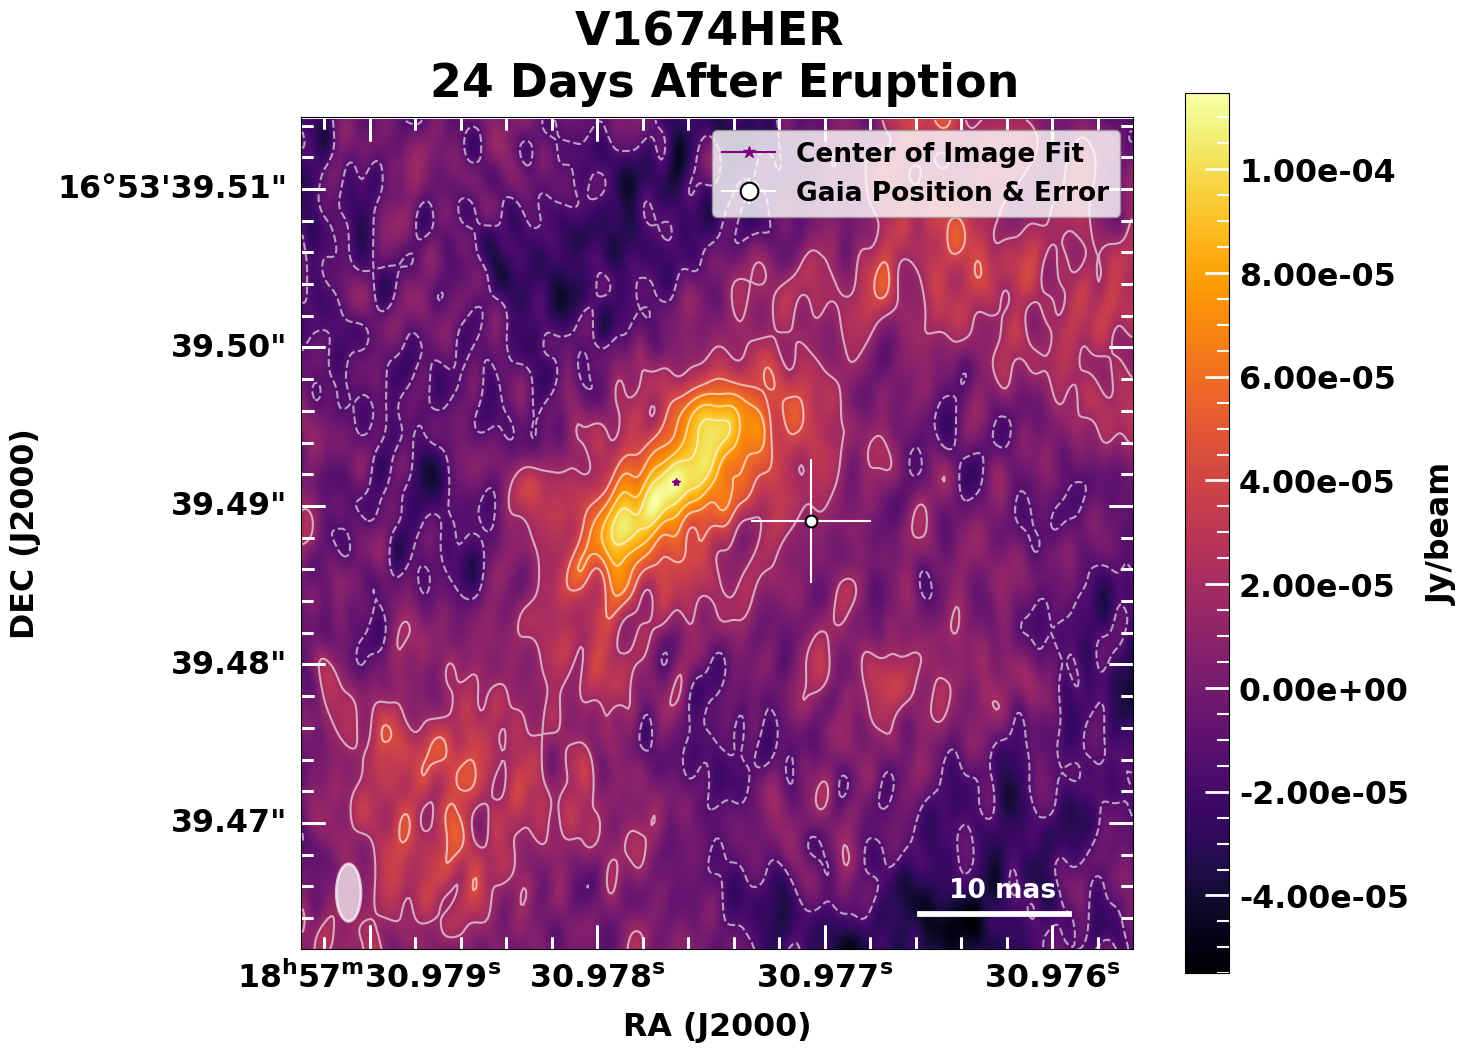

In [11]:
plt.style.use('./presentation.mplstyle');

figd = plt.figure(figsize=(13,11));
axd = figd.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_d = axd.coords[0];
dec_d = axd.coords[1];


axd.set_title(f'V1674HER \n 24 Days After Eruption');

imgb = axd.imshow(cutd_data, cmap='inferno', vmin=imgd_info['min'], vmax=imgd_info['max'], 
                 transform=axd.get_transform(cut_wcsd), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutd_center, beamd, 10, axd, finetune_ra=-3);
beamb_patch = beam_plotter(beamd, cutd_center, axd);


cbar_d = figd.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

ra_d.set_axislabel('RA (J2000)');
dec_d.set_axislabel('DEC (J2000)');

ra_d.set_ticklabel('black'); #required
dec_d.set_ticklabel('black');

axd.add_patch(beamb_patch);
axd.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgd_info['rms']*contour_levels_array;
axd.contour(cutd_data, levels=contour_levels ,transform=axd.get_transform(cut_wcsd), colors='w', alpha=0.6);

axd.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axd.get_transform('fk5'), color='w');

axd.errorbar(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axd.get_transform('fk5'),
           color='purple', marker='*', label='Center of Image Fit');

axd.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axd.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
axd.legend();

### V1674HERF

In [12]:
imgf_data, wcsf, imagef = load('./V1674HERIMG/0130/V1674HERF_CLN.fits');

imgf_info, imgf_cnt = info(imagef);

beamf = beam(imagef);

cutf_data, cut_wcsf, cutf_center = cut(imgf_data, wcsf, imgf_cnt, center_pos=modelfitb_coords, box=(350,350));

obstime_f = time.Time(imgf_info['obs_date'], scale='utc');
obstime_f.format = ('jd');
# obstime_b.scale = ('utc');

t_f = obstime_f - t_0;


time_diff_f = (obstime_f - gaia_time);
time_diff_f = (time_diff_f.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_f)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_f*rapm_err)**2)**(1/2);

/var/folders/k8/d570h55x0jddd1svnvdqq5m40000gn/T/ipykernel_56481/973989705.py:126: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  sbar = Rectangle((sbar_rad, sbar_dec), width = sbarwidth, height = beam_dict['b_minor']/10,


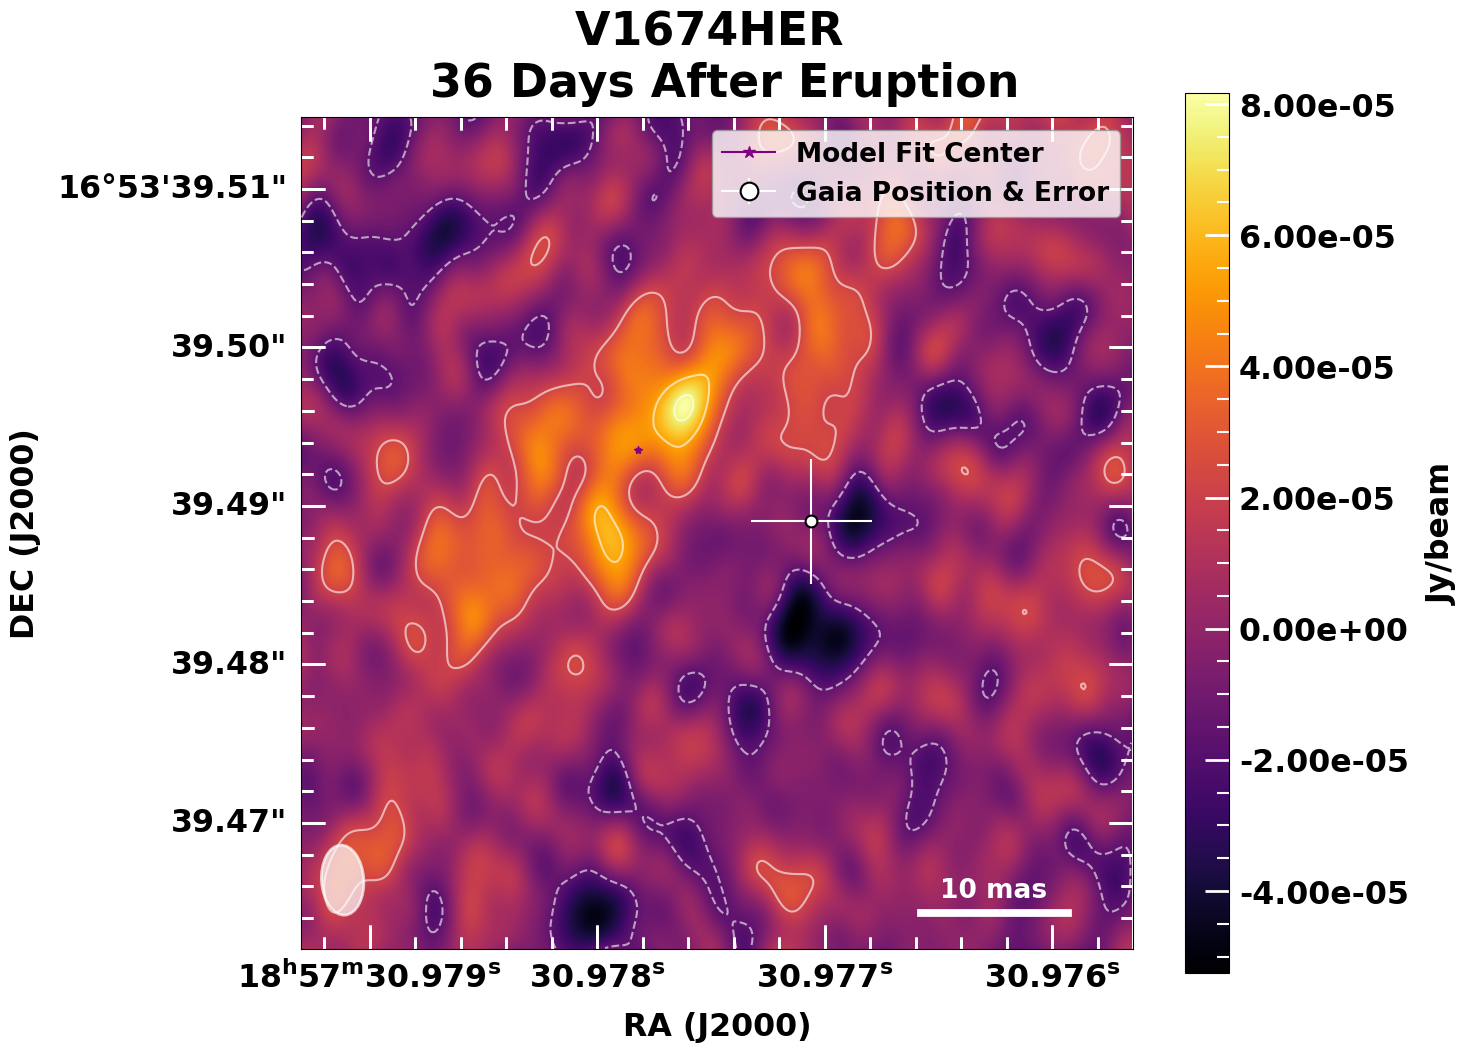

In [13]:
plt.style.use('./presentation.mplstyle');

figf = plt.figure(figsize=(13,11));
axf = figf.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
rad_f = axf.coords[0];
dec_f = axf.coords[1];


axf.set_title(f'V1674HER \n 36 Days After Eruption');

imgb = axf.imshow(cutf_data, cmap='inferno', vmin=imgf_info['min'], vmax=imgf_info['max'], 
                 transform=axf.get_transform(cut_wcsf), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutf_center, beamf, 10, axf, finetune_ra=-7);
beamf_patch = beam_plotter(beamf, cutf_center, axf);


cbar_d = figf.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

rad_f.set_axislabel('RA (J2000)');
dec_f.set_axislabel('DEC (J2000)');

rad_f.set_ticklabel('black'); #required
dec_f.set_ticklabel('black');

axf.add_patch(beamf_patch);
axf.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgf_info['rms']*contour_levels_array;
axf.contour(cutf_data, levels=contour_levels ,transform=axf.get_transform(cut_wcsf), colors='w', alpha=0.6);

axf.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axf.get_transform('fk5'), color='w');
v1674herf_coords = SkyCoord('18:57:30.9747036153', '16:53:39.4639746068', unit=(un.hourangle, un.deg), frame='icrs').transform_to(frame='fk5');

axf.errorbar(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axf.get_transform('fk5'),
           color='purple', marker='*', label='Model Fit Center');

axf.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axf.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
axf.legend();

## Check & Phase Reference Source

In [14]:
# checksrcb, checksrcb_coords = difmap_model_read('./check/fitb.txt');
checkb_coords = SkyCoord('19:04:46.2574282526', '16:03:15.0463412082', unit=(un.hourangle, un.deg));
checkd_coords = SkyCoord('19:04:46.2574099526','16:03:15.0463069188', unit=(un.hourangle, un.deg));
checkf_coords = SkyCoord('19:04:46.2574062314','16:03:15.0463550053', unit=(un.hourangle, un.deg));
checkf_coords_icrs = SkyCoord('19:04:46.254662979', '16:03:15.0221210724', unit=(un.hourangle, un.deg), frame='icrs');
v1674herb_coords = SkyCoord('18:57:30.9747036153', '16:53:39.4639746068', unit=(un.hourangle, un.deg), frame='icrs');



checksched_coords = SkyCoord('19:04:46.2573', '+16:03:15.046', unit=(un.hourangle, un.degree)); #1902+159
prsched_coords = SkyCoord('18:57:25.5956', '+16:24:55.841', unit=(un.hourangle, un.degree)); #1855+163
ffsched_coords = SkyCoord('17:51:32.8186', '+09:39:00.728', unit=(un.hourangle, un.deg)); #1749+096
v1674her_sched = SkyCoord('18:57:30.979', '+16:53:39.54', unit=(un.hourangle, un.deg));

checkcal_coords = SkyCoord('19:04:46.25735000', '+16:03:15.0459200', unit=(un.hourangle, un.deg)); #RFC
prcal_coords = SkyCoord(' 18:57:25.59555586 ', '+16:24:55.8404388', unit=(un.hourangle, un.degree));


In [15]:
sep_bd = (checkb_coords.separation(checkd_coords));
sep_df = (checkf_coords.separation(checkd_coords));
sep_bf = (checkb_coords.separation(checkf_coords));

sep_schedcal = (checksched_coords.separation(checkcal_coords)).to(un.mas);
sep_schedb = (checksched_coords.separation(checkb_coords)).to(un.mas);


print(sep_bd, sep_df, sep_bf);
print(sep_schedcal, sep_schedb);
print(checksched_coords.separation(checkf_coords_icrs).to(un.mas));
print(shifted_gaia.separation(modelfitb_coords));
modelfitb_coords

0d00m00.00026601s 0d00m00.00007204s 0d00m00.00031774s
0.725177 mas 1.87999 mas
44.8906 mas
0d00m00.02684401s


<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (284.3790728, 16.89430228)>

In [16]:
dist = (6.3e3)*un.pc
dis_per = 3.8e3*un.pc;
dis_ner = 2.8e3*un.pc;

D = np.tan(sep_bd.to(un.arcsec))*dist;
print(D.to(un.AU))

1.6758873692660503 AU


In [17]:
carta_icrs = SkyCoord('18:57:25.5928698300', '+16:24:55.8164494212', unit=(un.hourangle, un.deg), frame='icrs');
RCF_icrs = SkyCoord('18:57:25.59555586', '+16:24:55.8404388', unit=(un.hourangle, un.degree), frame='icrs');

diff = carta_icrs.separation(RCF_icrs).to(un.mas);
img_diff = shifted_gaia.separation(modelfitb_coords).to(un.mas);
print(diff, img_diff);

45.4881 mas 26.844 mas


In [18]:
sep_s = (shifted_gaia.ra.degree - modelfitf_coords.ra.degree)**2 + ((shifted_gaia.dec.degree - modelfitf_coords.dec.degree)**2)
sep = (sep_s)**(1/2)
sep_mas = (sep*un.degree).to(un.mas)
print(sep_mas)

12.256751928674197 mas


## Magnetic Field

In [19]:
# modelfitb.iloc[0,1]
# modelfitb
B_eq_40b, B_min_40b = magnetic_field(MinorD_b, modelfitb.iloc[0,0], modelfitb.iloc[0,9], modelfitb.iloc[0,15]);
B_eq_100b, B_min_100b = magnetic_field(MinorD_b, modelfitb.iloc[0,0], modelfitb.iloc[0,9], modelfitb.iloc[0,15], K_o=100);
B_eq_40d, B_min_40d = magnetic_field(MinorD_d, modelfitd.iloc[0,0], modelfitd.iloc[0,9], modelfitd.iloc[0,15]);
B_eq_100d, B_min_100d = magnetic_field(MinorD_d, modelfitd.iloc[0,0], modelfitd.iloc[0,9], modelfitd.iloc[0,15], K_o=100);
B_eq_40f, B_min_40f = magnetic_field(MinorD_f, modelfitf.iloc[0,0], modelfitf.iloc[0,9], modelfitf.iloc[0,15]);
B_eq_100f, B_min_100f = magnetic_field(MinorD_f, modelfitf.iloc[0,0], modelfitf.iloc[0,9], modelfitf.iloc[0,15], K_o=100);
# print(f'{B:.3E}');

0.07011342266562771 Gauss, K_0: 40 path length (cm): 8.90E+13
0.08945860441800468 Gauss, K_0: 100 path length (cm): 8.90E+13
0.06362972672923146 Gauss, K_0: 40 path length (cm): 4.83E+13
0.08118597461490927 Gauss, K_0: 100 path length (cm): 4.83E+13
0.03680740106312947 Gauss, K_0: 40 path length (cm): 6.86E+13
0.04696302941969442 Gauss, K_0: 100 path length (cm): 6.86E+13


In [20]:
b_eq, b_min = magnetic_field(MinorD_b, modelfitb.iloc[0,0], modelfitb.iloc[0,9], modelfitb.iloc[0,15], si=-0.9);

0.038603392597480066 Gauss, K_0: 40 path length (cm): 8.90E+13


#### Velocity

In [21]:
# input = (10*un.mas).to(un.arcsec).value
# input = (modelfitb_coords.separation(modelfitf_coords)).to(un.arcsec);
# size, _ = angular_size(6.3e3, input.value);
# vel = (size/((36-21)*un.day)).to(un.km/un.s);
# vel_mas = (input/((36-21)*un.day)).to(un.mas/un.day);
# print(vel, vel_mas)

dist_bd = (modelfitb_coords.separation(modelfitd_coords)).to(un.arcsec);
size_bd, _ = angular_size(6.3e3, dist_bd.value);
dist_df = (modelfitd_coords.separation(modelfitf_coords)).to(un.arcsec);
size_df, _ = angular_size(6.3e3, dist_df.value);
# bd = ((21-24)*un.day).to(un.s)
vel_bd = (size_bd/((24-21)*un.day)).to(un.km/un.s);#.to(un.mas/un.day)
vel_df = (size_df/((36-24)*un.day)).to(un.km/un.s);


print(f'{vel_bd:.2E}')
size_bd

1.278E-04 pc 2.636E+01 AU
9.575E-05 pc 1.975E+01 AU
1.52E+04 km / s


<Quantity 0.0001278 pc>

In [22]:
c = imgb_info['rms']*1e6
d = imgb_info['max']*1e6
a = (modelfitf.iloc[0,11]*un.arcsec).to(un.mas);
b = (modelfitf.iloc[0,9]*un.arcsec).to(un.mas);
print(a,b)


7.2749999999999995 mas 23.569999999999997 mas


In [23]:
a = (beamf['b_major']*un.degree).to(un.mas)
b = (beamf['b_minor']*un.degree).to(un.mas)

print(a,b)
modelfitb.iloc[0,9]

4.421519792861399 mas 2.7878547602312276 mas


0.01071

In [24]:
imgf_info

{'obs_code': 'BA142F',
 'obs_date': '2021-07-17',
 'obsra': 284.379079167,
 'obsdec': 16.8943166667,
 'rms': 1.0930396456388e-05,
 'min': -5.254639472696e-05,
 'max': 8.1637139373925e-05}

In [25]:
T_b = brightness_temp(modelfitb.iloc[0,9], modelfitb.iloc[0,11], modelfitb.iloc[0,0], modelfitb.iloc[0,15]);
T_d = brightness_temp(modelfitd.iloc[0,9], modelfitd.iloc[0,11], modelfitd.iloc[0,0], modelfitd.iloc[0,15]);
T_f = brightness_temp(modelfitf.iloc[0,9], modelfitf.iloc[0,11], modelfitf.iloc[0,0], modelfitf.iloc[0,15]);

3.72E+06
3.23E+06
7.55E+05


In [26]:
modelfitd

,Flux (Jy),Flux (jy) Std,East (arcsec),RA (arcsec) Std,North (arcsec),Dec (arcsec) Std,Shape,R.A. (deg),Dec (deg),Major FWHM (arcsec),Major Std,Minor FWHM (arcsec),Minor Std,Theta (deg),Theta Std,Freq (Hz),Spectral Index,Spec Indx Std
0,0.000984,0.000038,-0.004979,0.00019,-0.00051,0.0002,gauss,284.379074,16.894303,0.01329,0.00036,0.005118,0.00094,-45.71,2.7,4.867750e+09,0.0,0.0


## Light Curve

### Generic Plot

In [27]:
lc_df = pd.read_csv('./tables/V1674HERLC.csv',delimiter=',');

VLBA = pd.DataFrame([[t_b.value, (modelfitb.iloc[0,0]*1e3)],[t_d.value,modelfitd.iloc[0,0]*1e3], [t_f.value, modelfitf.iloc[0,0]*1e3]],
                    columns = ['Day',  'Flux']);

bands = pd.DataFrame([['c', 5.1],['x', 7.0],['ku', 13.7],['k', 16.5],['ka', 31.1],['q', 34.9]],
                     columns=['name','freq']);
# lc_c = lc_df.loc[lc_df['Freq'] == 5.1]
# lc_x = lc_df.loc[lc_df['Freq'] == 7.0]
# lc_ku = lc_df.loc[lc_df['Freq'] == 13.7]
# lc_k = lc_df.loc[lc_df['Freq'] == 16.5]
# lc_ka = lc_df.loc[lc_df['Freq'] == 31.1]
# lc_q = lc_df.loc[lc_df['Freq'] == 34.9]

for i in range(0, len(bands)):
    
    name_i = bands.iloc[i,0];
    freq_i = bands.iloc[i,1];
    
    var_name = 'lc_' + str(name_i);
    globals()[var_name] = lc_df.loc[lc_df['Freq'] == freq_i];
    
    
    var_i = eval(var_name); 
    #create non-detection dataframes
    var_name2 = (var_name + '_nd');
    globals()[var_name2] = var_i.loc[var_i['Unnamed: 4'] == 'non-detection'];
    
    #create detection dataframes
    var_name3 = (var_name + '_d');
    globals()[var_name3] = (var_i.loc[var_i['Unnamed: 4'] != 'non-detection']);
    

#now have three dataframes:
    #lc_(band)_nd: which is all the ones which were indicated to be nondetections
    #lc_(band)_d: which are the ones which were indicated to be anything other than nondetections
    #lc_(band) which is a combination of the other two


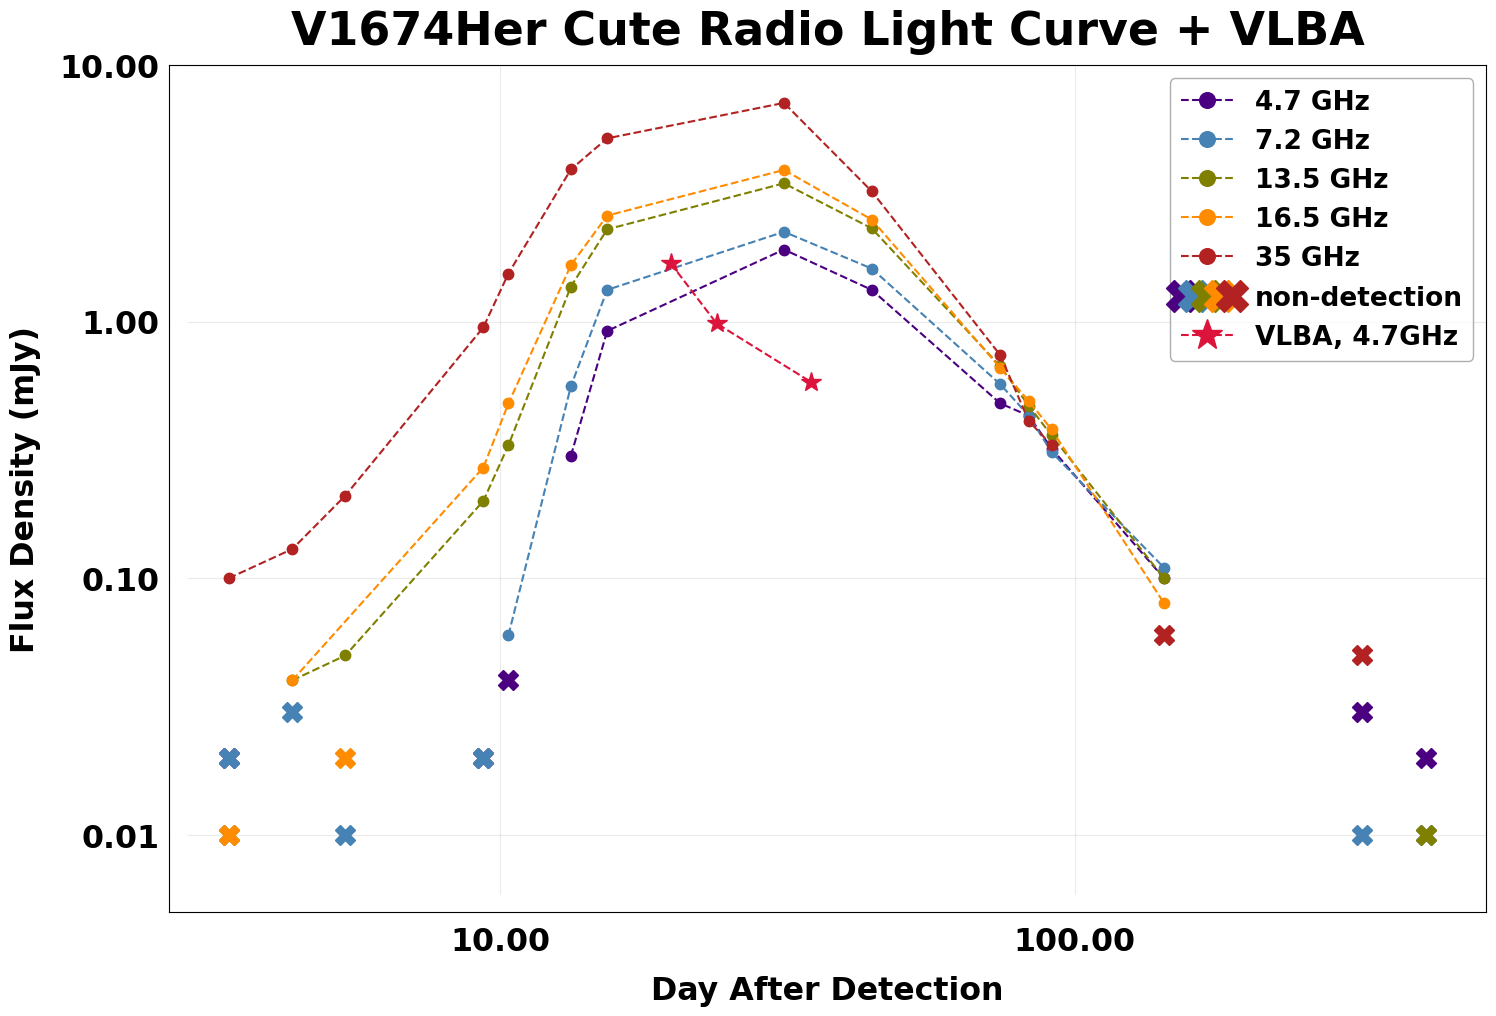

In [28]:
plt.style.use('./presentation.mplstyle');
fig, ax = plt.subplots(figsize=(17,11), facecolor='white');
plt.rcParams.update({'lines.markersize': 15});




line_c, = ax.plot(lc_c_d['Day'], lc_c_d['Flux'], linestyle='dashed' , marker='.', color='indigo');
line_x, = ax.plot(lc_x_d['Day'], lc_x_d['Flux'], linestyle='dashed',  marker='.' , color='steelblue');
line_ku, = ax.plot(lc_ku_d['Day'], lc_ku_d['Flux'],linestyle='dashed', marker='.' , color='olive');
line_k, = ax.plot(lc_k_d['Day'], lc_k_d['Flux'], linestyle='dashed', marker='.' , color='darkorange');
line_q, = ax.plot(lc_q_d['Day'], lc_q_d['Flux'], linestyle='dashed', marker='.' , color='firebrick');


#ax.errorbar(lc_ka_d['Day'], lc_ka_d['Flux'], linestyle='dashed', linewidth=0.75,marker='.', color='firebrick', label='31 GHz');
#non-detections
line_c_nd, = ax.plot(lc_c_nd['Day'], lc_c_nd['Flux'], marker='X', linestyle='none',    color='indigo');
line_x_nd, = ax.plot(lc_x_nd['Day'], lc_x_nd['Flux'], marker='X', linestyle='none',   color='steelblue');
line_ku_nd, = ax.plot(lc_ku_nd['Day'], lc_ku_nd['Flux'], marker='X',linestyle='none',    color='olive');
line_k_nd, = ax.plot(lc_k_nd['Day'], lc_k_nd['Flux'], marker='X', linestyle='none',   color='darkorange');
#ax.scatter(lc_ka_nd['Day'], lc_ka_nd['Flux'], marker='+', color='firebrick');
line_q_nd, = ax.plot(lc_q_nd['Day'], lc_q_nd['Flux'], marker='X',   linestyle='none', color='firebrick');

# ax.errorbar()
#VLBA
line_VLBA, = ax. plot(VLBA['Day'], VLBA['Flux'], linestyle='dashed', marker='*', markersize=15, color='crimson');

ax.set_xscale('log');
ax.set_yscale('log');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.tick_params(which='both', direction='in', length=13, width=2);
ax.legend([line_c, line_x, line_ku, line_k, line_q, (line_c_nd, line_x_nd, line_ku_nd, line_k_nd, line_q_nd), line_VLBA],
          ['4.7 GHz', '7.2 GHz', '13.5 GHz', '16.5 GHz', '35 GHz', 'non-detection','VLBA, 4.7GHz' ], handler_map={tuple: HandlerTuple(ndivide=None)});

ax.grid(True, alpha=0.25);

#ax.set_xlim(7,1000);
ax.set_ylim(0.005, 10);
ax.set_title('V1674Her Cute Radio Light Curve + VLBA');
ax.set_ylabel('Flux Density (mJy)');
ax.set_xlabel('Day After Detection');

##### LC with error bars

/var/folders/k8/d570h55x0jddd1svnvdqq5m40000gn/T/ipykernel_56481/2280795502.py:33: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend([line_c, line_x, line_ku, line_k, line_q, (line_c_nd, line_x_nd, line_ku_nd, line_k_nd, line_q_nd), line_VLBA],


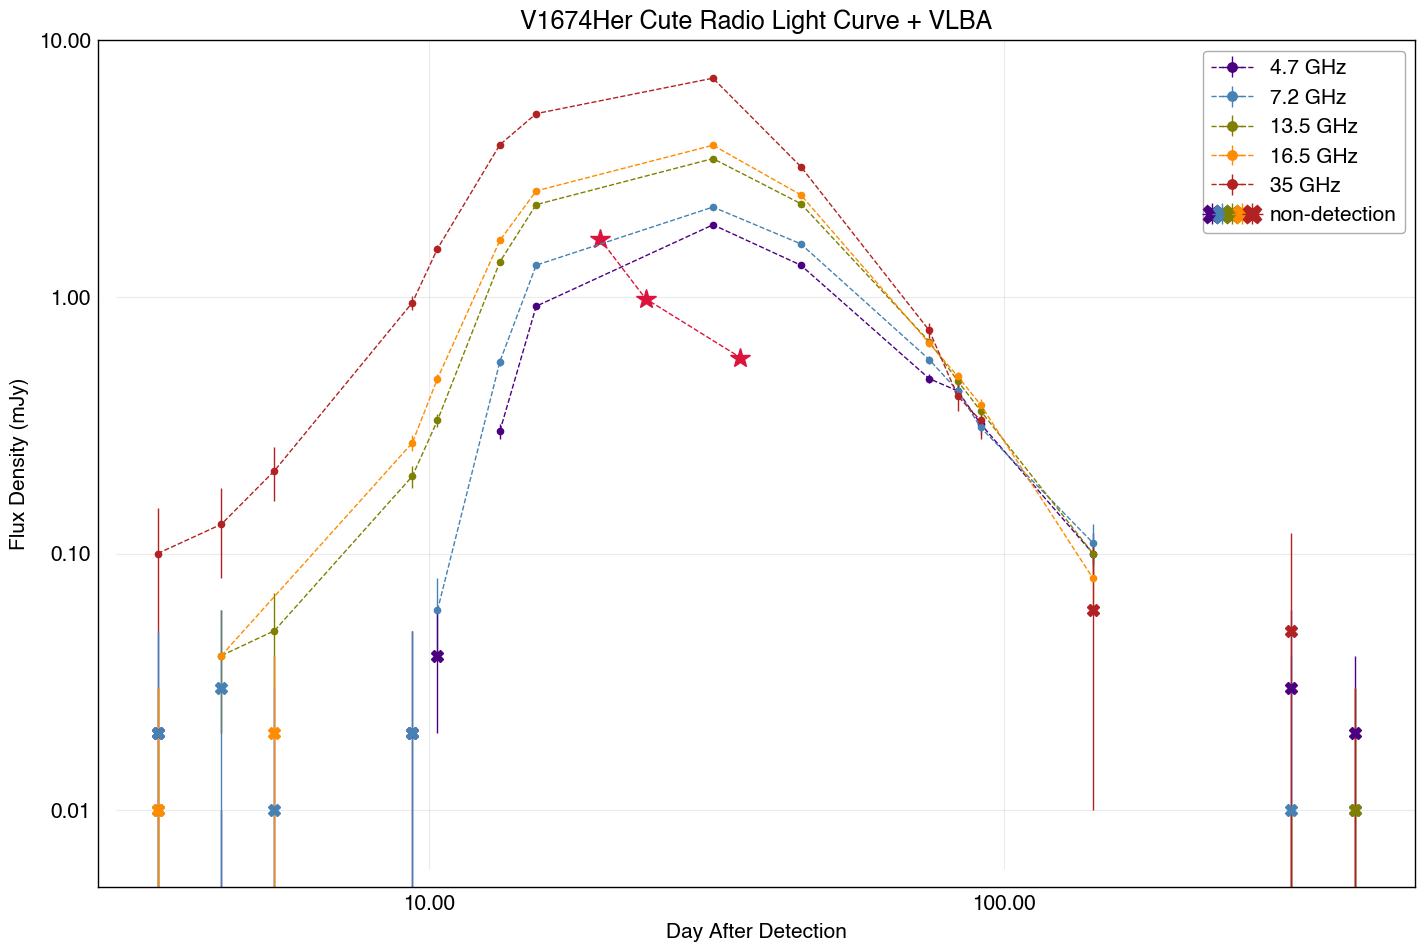

In [29]:
plt.style.use('light');
fig, ax = plt.subplots(figsize=(17,11), facecolor='white');
plt.rcParams.update({'lines.markersize': 9});




line_c = ax.errorbar(lc_c_d['Day'], lc_c_d['Flux'], xerr=0, yerr=lc_c_d['Error'], linestyle='dashed' , marker='.', color='indigo');
line_x = ax.errorbar(lc_x_d['Day'], lc_x_d['Flux'], xerr=0, yerr=lc_x_d['Error'], linestyle='dashed',  marker='.' , color='steelblue');
line_ku = ax.errorbar(lc_ku_d['Day'], lc_ku_d['Flux'], xerr=0, yerr=lc_ku_d['Error'],linestyle='dashed', marker='.' , color='olive');
line_k = ax.errorbar(lc_k_d['Day'], lc_k_d['Flux'],xerr=0, yerr=lc_k_d['Error'], linestyle='dashed', marker='.' , color='darkorange');
line_q = ax.errorbar(lc_q_d['Day'], lc_q_d['Flux'], xerr=0, yerr=lc_q_d['Error'],linestyle='dashed', marker='.' , color='firebrick');


#ax.errorbar(lc_ka_d['Day'], lc_ka_d['Flux'], linestyle='dashed', linewidth=0.75,marker='.', color='firebrick', label='31 GHz');
#non-detections
line_c_nd = ax.errorbar(lc_c_nd['Day'], lc_c_nd['Flux'], xerr=0, yerr=lc_c_nd['Error'], marker='X', linestyle='none',    color='indigo');
line_x_nd = ax.errorbar(lc_x_nd['Day'], lc_x_nd['Flux'], xerr=0, yerr=lc_x_nd['Error'], marker='X', linestyle='none',   color='steelblue');
line_ku_nd = ax.errorbar(lc_ku_nd['Day'], lc_ku_nd['Flux'], xerr=0, yerr=lc_ku_nd['Error'], marker='X',linestyle='none',    color='olive');
line_k_nd = ax.errorbar(lc_k_nd['Day'], lc_k_nd['Flux'], xerr=0, yerr=lc_k_nd['Error'],marker='X', linestyle='none',   color='darkorange');
#ax.scatter(lc_ka_nd['Day'], lc_ka_nd['Flux'], marker='+', color='firebrick');
line_q_nd = ax.errorbar(lc_q_nd['Day'], lc_q_nd['Flux'],xerr=0, yerr=lc_q_nd['Error'], marker='X',   linestyle='none', color='firebrick');

# ax.errorbar()
#VLBA
line_VLBA = ax.plot(VLBA['Day'], VLBA['Flux'], linestyle='dashed', marker='*', markersize=15, color='crimson');

ax.set_xscale('log');
ax.set_yscale('log');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.tick_params(which='both', direction='in', length=13, width=2);
ax.legend([line_c, line_x, line_ku, line_k, line_q, (line_c_nd, line_x_nd, line_ku_nd, line_k_nd, line_q_nd), line_VLBA],
          ['4.7 GHz', '7.2 GHz', '13.5 GHz', '16.5 GHz', '35 GHz', 'non-detection','VLBA, 4.7GHz' ], handler_map={tuple: HandlerTuple(ndivide=None)});

ax.grid(True, alpha=0.25);

#ax.set_xlim(7,1000);
ax.set_ylim(0.005, 10);
ax.set_title('V1674Her Cute Radio Light Curve + VLBA');
ax.set_ylabel('Flux Density (mJy)');
ax.set_xlabel('Day After Detection');

In [30]:
# lc_partial_1 = lc_c_nd.iloc[4:5,:];
lc_partial_2 = lc_c_nd.iloc[5:7,:];

# print(lc_partial_1)
# lc_c = pd.concat([lc_partial_1,lc_c_d], ignore_index=True);
lc_c = pd.concat([lc_c_d,lc_partial_2], ignore_index=True);

x0 = np.linspace(lc_c.iloc[0,0], lc_c.iloc[-1,0], num=100);
lc_c.iloc[0:8,0]

0     13.28
1     15.36
2     31.19
3     44.34
4     74.21
5     83.19
6     91.15
7    142.99
Name: Day, dtype: float64

### Fitting the LC

#### Simple Broken Power Law Fit 

In [31]:
#this was a crapshoot, but also gets some decent initial values

p_init = models.BrokenPowerLaw1D(amplitude=2, x_break=19, alpha_1=0.7, alpha_2=-1); ## init power law
fit_p = fitting.LevMarLSQFitter(); ## which fitter to use
p = fit_p(p_init, lc_c.iloc[0:8,0], lc_c.iloc[0:8,2], maxiter=10000); ## fit the data
p


<BrokenPowerLaw1D(amplitude=4.32689215, x_break=18.78019594, alpha_1=-7.7012563, alpha_2=1.54015637)>

In [32]:
t = lc_c.iloc[:,0].to_numpy(dtype=np.float128);
y = lc_c.iloc[:,2].to_numpy(dtype=np.float128);
yerr = lc_c.iloc[:,3].to_numpy(dtype=np.float128);
# t = np.array(t, dtype=np.float256);
# y = np.array(y, dtype=np.float256);
# yerr = np.array
t,y,yerr = [np.array(x[:-4]) for x in [t,y,yerr]];
# t,y,yerr = [np.array(x[1:]) for x in [t,y,yerr]];
x0 = np.linspace(t[0], t[-1], num=100);
t

array([13.28, 15.36, 31.19, 44.34, 74.21, 83.19], dtype=float128)

#### EMCEE fit

#### Maximum Likelihood Estimate

In [33]:
def broken_powerlaw(t, t_b, s, beta_1, beta_2, F_c):
    #Granot & sari 2002
    
    a = (t/t_b)**(-s*beta_1);
    b = (t/t_b)**(-s*beta_2);

    F_nu = F_c*(a+b)**(-1/s);
    
    return F_nu
    


def log_likelihood(theta, t, y, yerr):
    t_b, s, beta_1, beta_2, F_c = theta;
    #Granot & sari 2002

    model = broken_powerlaw(t, t_b, s, beta_1, beta_2, F_c);
    
    return -0.5 * np.sum((y - model) ** 2 / yerr + np.log(yerr))

nll = lambda *args: -log_likelihood(*args);

initial = np.array([p.x_break.value, 0.5, p.alpha_1.value, p.alpha_2.value, p.amplitude.value]);
# initial = np.array([5, 0.5, -7, 1, 5]);
soln = minimize(nll, initial, args=(t, y, yerr),  method='Nelder-Mead', options={'disp':True, 'maxiter':1000});
#print(soln);
#t_bml, s_ml, beta_1ml, beta_2ml, F_cml = soln.x;
t_bml, s_ml, beta_1ml, beta_2ml, F_cml = soln.x;

# # print(t_bml, s_ml, beta_1ml, beta_2ml, F_cml);
newy = broken_powerlaw(x0, t_bml, s_ml, beta_1ml, beta_2ml, F_cml);
print(t_bml, s_ml, beta_1ml, beta_2ml, F_cml);
# print(y)

Optimization terminated successfully.
         Current function value: -11.047127
         Iterations: 491
         Function evaluations: 783
17.95360367367067 0.9519753605156298 -1.453554406855277 8.586967624896648 4.332013686824098


#### Now actually MCMC

In [34]:
def log_prior(theta):
    t_b, s, beta_1, beta_2, F_c = theta;
    # print(theta);
    if 10 < t_b < 25  and 0.1 < s < 1.5 and -3 < beta_1 < 0 and 5 < beta_2 < 10 and 1 < F_c < 10:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta);
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)



In [35]:
pos = soln.x + 0.1*np.random.randn(64, 5);
nwalkers, ndim = pos.shape;

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t, y, yerr));

sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:24<00:00, 400.19it/s]


In [37]:
tau = sampler.get_autocorr_time();

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [184.98212801 303.60272129 222.29542626 151.10203962 349.16762091]

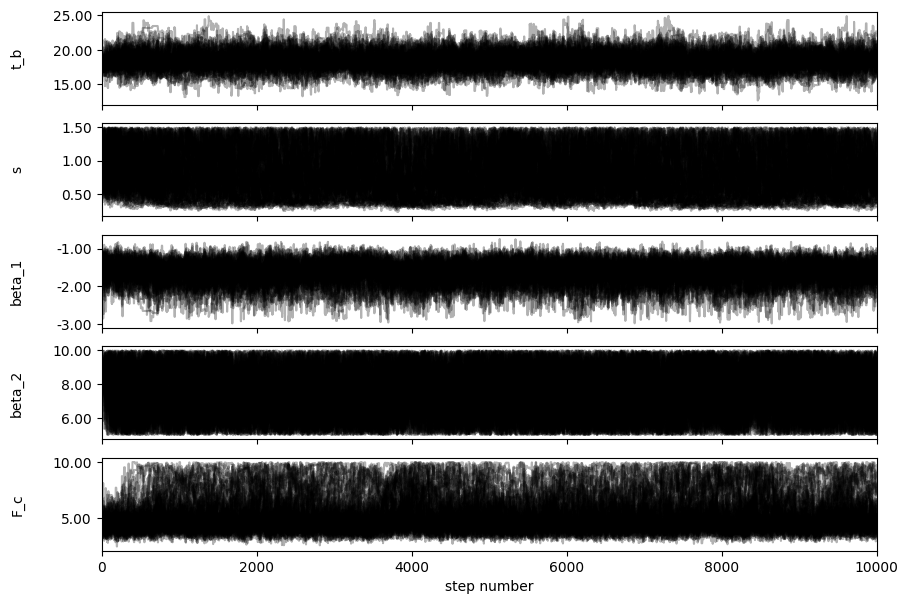

In [38]:
#check sampler
plt.style.use('default');
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True);

samples = sampler.get_chain();

labels = ["t_b", "s", "beta_1", "beta_2", "F_c"];


for i in range(ndim):
    ax = axes[i]
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [95]:
# tau = sampler.get_autocorr_time();
# print(tau);
flat_samples = sampler.get_chain(discard=664, thin=300, flat=True);
print(flat_samples.shape);



(1984, 5)


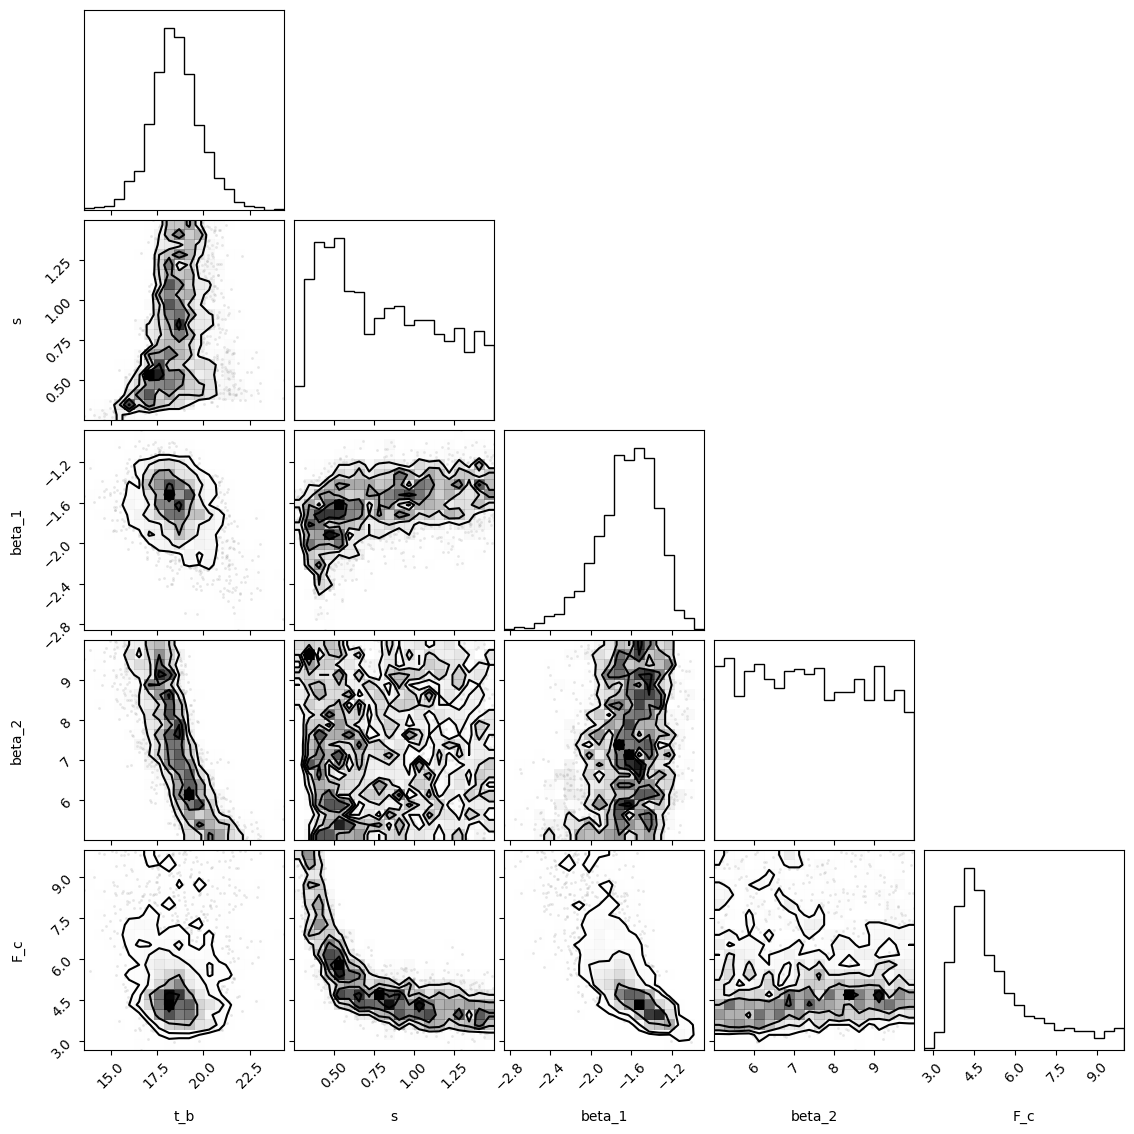

In [96]:
fig = corner.corner(flat_samples, labels=labels)

[]

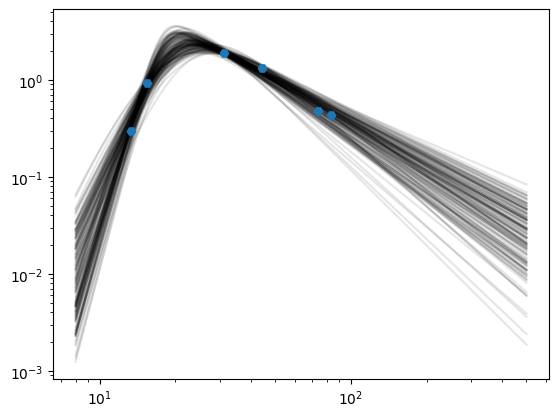

In [98]:
import random
t_plot = np.linspace(8,500,10000)
plt.errorbar(t,y,yerr,fmt = 'H')
for i in range(150):
    theta = random.choice(flat_samples)
    t_b, s, beta_1, beta_2, F_c = theta
    model = broken_powerlaw(t_plot, t_b, s, beta_1, beta_2, F_c)
    plt.plot(t_plot,model,alpha = 0.1, color = 'black')

plt.loglog()

#### Kantharia et al 2007

In [ ]:
# def sn_model(t, K1, K2, K3, alpha, beta, delta, delta_prime, t0, nu):
    

In [ ]:
plt.style.use('light');
fig, ax = plt.subplots(figsize=(17,11), facecolor='white');

plt.rcParams.update({'lines.markersize': 9});


fit = lc_c_d.iloc[1:3,:]



line_c, = ax.plot(lc_c_d['Day'], lc_c_d['Flux'], linestyle='dashed' , marker='.', color='indigo');

line_c_nd, = ax.plot(lc_c_nd['Day'], lc_c_nd['Flux'], marker='X', linestyle='none',  markersize=7, color='indigo');

# Line fit
# linear_model = np.polyfit(x, y, 1)
# linear_model_fn = np.poly1d(linear_model)
# x_s = np.arange(0, 7)
# plt.plot(x_s, linear_model_fn(x_s), color="green")


# fit_model = np.polyfit(lc_c['Day'], lc_c['Flux'], deg=1);
# fit_model_fqn = np.poly1d(fit_model);



# ax.plot(x, fit_model_fqn(x));
# VLA_flux_19 = fit_model_fqn(VLBA.iloc[0,0]);

# ax.plot(VLBA.iloc[0,0], VLA_flux_19, marker='+')

line_VLBA, = ax.plot(VLBA['Day'], VLBA['Flux'], linestyle='dashed', marker='*', markersize=9, color='crimson');

ax.set_xscale('log');
ax.set_yscale('log');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.tick_params(which='both', direction='in', length=13, width=2);
# ax.legend([line_c, line_x, line_ku, line_k, line_q, (line_c_nd, line_x_nd, line_ku_nd, line_k_nd, line_q_nd), line_VLBA],
#           ['4.7 GHz', '7.2 GHz', '13.5 GHz', '16.5 GHz', '35 GHz', 'non-detection','VLBA, 4.7GHz' ], handler_map={tuple: HandlerTuple(ndivide=None)});

ax.grid(True, alpha=0.25);

#ax.set_xlim(7,1000);
ax.set_ylim(0.005, 10);
ax.set_title('V1674Her Cute Radio Light Curve + VLBA', fontsize=27, weight='bold');
ax.set_ylabel('Flux Density (mJy)', fontsize=17, weight='bold');
ax.set_xlabel('Day After Detection', fontsize=17, weight='bold');

ax.plot(x0, newy, ":k", label="ML");
# ax.plot(lc_c['Day'], gamma_plt, color='orange');
# x_cheby, y_cheby = fit_cmodel.linspace();
# ax.plot(lc_c['Day'], power_y, marker='.', color='blue');
# ax.plot(x0, p(x0), marker='.', label='astropy broken powerlaw fit');

# inds = np.random.randint(len(flat_samples), size=10);
# for ind in inds:
#     sample = flat_samples[ind]
#     ax.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1);

ax.legend();

